In [1]:
import numpy as np
import os
from nd2reader import ND2Reader
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib_scalebar.scalebar import ScaleBar
import scipy.ndimage as ndi
from skimage.filters import rank 
from scipy.signal import butter, lfilter
import scipy.misc as misc
from skimage import exposure
from PIL import Image
import colorcet as cc
from scipy.misc import toimage
import matplotlib.colors as clr
import pandas as pd
import seaborn as sns
from scipy import stats
import cv2
from pyspark import SparkContext, SparkConf
import skimage
from pathlib import Path

def mean2(x):
    y = np.sum(x) / np.size(x);
    return y
def corr2(a,b):
    a = a - mean2(a)
    b = b - mean2(b)

    r = (a*b).sum() / np.sqrt((a*a).sum() * (b*b).sum());
    return r
from copy import deepcopy
from skimage.filters import threshold_otsu,threshold_li
import glob
from IPython.display import clear_output
import scipy.io as spio
import pims
from skimage.measure import label, regionprops
from skimage.color import label2rgb
import scipy

In [2]:
expdir='/Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture_ClickChemistry/' #master folder
protein="TNR" #TNR,Agg,WFA,HABP

In [3]:
results = {"filename":[],
          "exp condition":[],
          "ecmchannelno":[],
          "funcatchannelno":[]
          }
           
path = os.path.dirname(expdir)  
outputFolder = os.path.dirname(expdir + "/new/")
filelist = []
for root, _, filenames in os.walk(path):
     for filename in filenames:
         filelist.append(os.path.join(root, filename))      
for i in range(0,len(filelist)):
    if "STED" in str(filelist[i]):
        if "_analyse519" in str(filelist[i]):
            if ("Focus" in str(filelist[i]))==False:
                if ("save" in str(filelist[i]))==False:
                    if (protein in str(filelist[i]))==True:
                        if filelist[i].endswith(".tif"): 
                            if str(filelist[i][:-12]) not in str(results["filename"]):

                                results["filename"].append(filelist[i][:-12])
                                results["exp condition"].append(filelist[i][:-12].split('/')[-2])
                                #channeldir="/".join(filelist[i][:-12].split("/")[:-2])
                                #exec(open(channeldir+"/channels.txt").read())
                                results["ecmchannelno"].append(2)
                                results["funcatchannelno"].append(1)


## Loading a random image

Image name: cs1_05_ExpControl
Experimental condition: TIF_imp


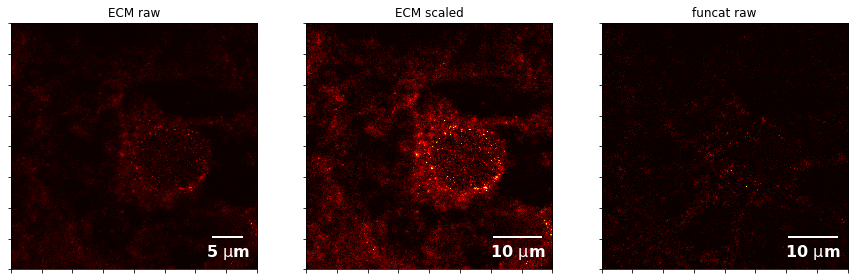

In [4]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=2
funcat_channel_no=1

funcat_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
ecm_image_name=results["filename"][randomno]+" Ch"+str(funcat_channel_no)+" {0}.tif"


print("Image name:",results["filename"][randomno].split('/')[-1])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
funcat_image=pims.open(funcat_image_name)[0]
   
figure=plt.figure(figsize=(15,15))
figure.add_subplot(131)
plt.imshow(ecm_image,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)
figure.add_subplot(132)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM scaled')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(25, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(133)
plt.imshow(funcat_image,interpolation='none',cmap='hot')
plt.title('funcat raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(25, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

## Find spots

### Load spots made from icy wavelet transform
For both channels - detection scale 2 (3 pixels), sensitivity 30

In [5]:
results["TNR spots mask"]=[]
results["funcat spots mask"]=[]
for i in range(0,len(results["filename"])):
    results["TNR spots mask"].append(np.nan)
    results["funcat spots mask"].append(np.nan)
for mask in range(0,len(results["filename"])):
    ecm_channel_no=results["ecmchannelno"][mask]
    funcat_channel_no=results["funcatchannelno"][mask]
    file_nametnr='/'.join(results["filename"][mask].split('/')[:-1])+'/save/'+results["filename"][mask].split('/')[-1]+' Ch'+str(ecm_channel_no)+' {0}.tif.roi.binary.tif'
    
    file_namefuncat='/'.join(results["filename"][mask].split('/')[:-1])+'/save/'+results["filename"][mask].split('/')[-1]+' Ch'+str(funcat_channel_no)+' {0}.tif.roi.binary.tif'

    tnrmask=cv2.imread(file_nametnr)
    funcatmask=cv2.imread(file_namefuncat)
    results["TNR spots mask"][mask]=tnrmask
    results["funcat spots mask"][mask]=funcatmask

### Random processed image

In [ ]:
#backup
ecm_image_raw=deepcopy(ecm_image)
funcat_image_raw=deepcopy(funcat_image)

In [ ]:
'''#2x2 binning --> new pixel size = 40nm
def rebin(arr, new_shape):
    shape = (new_shape[0], arr.shape[0] // new_shape[0],
             new_shape[1], arr.shape[1] // new_shape[1])
    return arr.reshape(shape).mean(-1).mean(1)
ecm_image=np.asarray(ecm_image_raw)
ecm_image=rebin(ecm_image,[512,512])
funcat_image=rebin(funcat_image_raw,[512,512])
synapse_image=rebin(synapse_image_raw,[512,512])'''

#bandpass
lowpass = ndi.gaussian_filter(ecm_image, 3)
ecm_image = ecm_image - lowpass
lowpass = ndi.gaussian_filter(funcat_image, 3)
funcat_image = funcat_image - lowpass


#binarize to find spots
ecm_image[ecm_image<1]=0
ecm_image[ecm_image>1]=1
funcat_image[funcat_image<1]=0
funcat_image[funcat_image>1]=1


#some morphological operations
#watershed attempt
'''from skimage.morphology import watershed
from skimage.feature import peak_local_max
distance = ndi.distance_transform_edt(ecm_image_high)
local_maxi = peak_local_max(distance, indices=False, 
                            footprint=np.ones((5, 5)), labels=ecm_image_high)
markers = ndi.label(local_maxi)[0]
labels = watershed(-distance, markers, mask=ecm_image_high)'''

ecm_image=ndi.binary_opening(ecm_image,iterations=3)
ecm_image=ndi.binary_closing(ecm_image,iterations=3)
funcat_image=ndi.binary_opening(funcat_image,iterations=4)
funcat_image=ndi.binary_closing(funcat_image,iterations=4)
#synapse_image=ndi.binary_opening(synapse_image,iterations=2)
#synapse_image=ndi.binary_closing(synapse_image,iterations=2)

figure=plt.figure(figsize=(15,15))
figure.add_subplot(221)
plt.imshow(ecm_image_raw,interpolation='none',cmap='hot')
plt.title('ECM raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

figure.add_subplot(222)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM spots')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

figure=plt.figure(figsize=(15,15))
figure.add_subplot(223)
plt.imshow(funcat_image_raw,interpolation='none',cmap='hot')
plt.title('funcat raw')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(20, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

figure.add_subplot(224)
plt.imshow(funcat_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('ECM spots')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(40, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)



## Batch analysis

### Find the spots in all images

## with otsu thresholding

In [ ]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest funcat centroid":[],
                  
                 "distance to nearest funcat centroid [nms]":[]
                  }
funcat_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                  
                       
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    funcat_image_name=results["filename"][image]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    ecm_image_name=results["filename"][image]+" Ch"+str(funcat_channel_no)+" {0}.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    funcat_image=pims.open(funcat_image_name)[0]
    
    ecm_image_threshold=threshold_otsu(ecm_image)
    ecm_image[ecm_image<ecm_image_threshold]=0
    ecm_image=ndi.binary_opening(ecm_image,iterations=10)
    ecm_image=ndi.binary_closing(ecm_image,iterations=10)
    
    funcat_image_threshold=threshold_otsu(funcat_image)
    funcat_image[funcat_image<funcat_image_threshold]=0
    funcat_image=ndi.binary_opening(funcat_image,iterations=10)
    funcat_image=ndi.binary_closing(funcat_image,iterations=10)

    
    labeled_ecm=label(ecm_image)
    labeled_funcat=label(funcat_image)
    #labeled_synapse=label(synapse_image)

    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_funcat=regionprops(labeled_funcat)
    #regionprops_synapse=regionprops(labeled_synapse)

    for i in range(0,len(regionprops_ecm)):
            ecm_spots_results["filename"].append(results["filename"][image])
            ecm_spots_results["exp condition"].append(results["exp condition"][image])
            ecm_spots_results["spotno"].append(i)
            ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
            ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_funcat)):
        funcat_spots_results["filename"].append(results["filename"][image])
        funcat_spots_results["exp condition"].append(results["exp condition"][image])
        funcat_spots_results["spotno"].append(i)
        funcat_spots_results["centroid"].append(regionprops_funcat[i]['centroid'])
        funcat_spots_results["size"].append(regionprops_funcat[i]['area'])


## with morphological operations

In [41]:
funcat_channel_no

1

In [ ]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest funcat centroid":[],
                  
                 "distance to nearest funcat centroid [nms]":[]
                  }
funcat_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                  
                       
                       "distance to nearest ecm centroid [nms]":[]}

for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read images
    funcat_image_name=results["filename"][image]+" Ch"+str(funcat_channel_no)+" {0}.tif"
    ecm_image_name=results["filename"][image]+" Ch"+str(ecm_channel_no)+" {0}.tif"
    ecm_image=pims.open(ecm_image_name)[0]
    funcat_image=pims.open(funcat_image_name)[0]
    #synapse_image=pims.open(synapse_image_name)[0]
    
    #backup
    ecm_image_raw=deepcopy(ecm_image)
    #synapse_image_raw=deepcopy(synapse_image)
    funcat_image_raw=deepcopy(funcat_image)
    
    #2x2 binning --> new pixel size = 40nm
    #ecm_image=np.asarray(ecm_image_raw)
    #ecm_image=rebin(ecm_image,[512,512])
    #funcat_image=rebin(funcat_image_raw,[512,512])
    #synapse_image=rebin(synapse_image_raw,[512,512])

    #bandpass
    lowpass = ndi.gaussian_filter(ecm_image, 2)
    ecm_image = ecm_image - lowpass
    lowpass = ndi.gaussian_filter(funcat_image, 2)
    funcat_image = funcat_image - lowpass
    #lowpass = ndi.gaussian_filter(synapse_image, 3)
    #synapse_image = synapse_image - lowpass

    #binarize to find spots
    ecm_image[ecm_image<1]=0
    ecm_image[ecm_image>1]=1
    funcat_image[funcat_image<1]=0
    funcat_image[funcat_image>1]=1
    #synapse_image[synapse_image<18]=0
    #synapse_image[synapse_image>18]=1
    
    #morphological operations
    ecm_image=ndi.binary_opening(ecm_image,iterations=3)
    ecm_image=ndi.binary_closing(ecm_image,iterations=3)
    funcat_image=ndi.binary_opening(funcat_image,iterations=3)
    funcat_image=ndi.binary_closing(funcat_image,iterations=3)
    #synapse_image=ndi.binary_opening(synapse_image,iterations=2)
    #synapse_image=ndi.binary_closing(synapse_image,iterations=2)
    
    labeled_ecm=label(ecm_image)
    labeled_funcat=label(funcat_image)
    #labeled_synapse=label(synapse_image)

    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_funcat=regionprops(labeled_funcat)
    #regionprops_synapse=regionprops(labeled_synapse)

    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'][0:2])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_funcat)):
        funcat_spots_results["filename"].append(results["filename"][image])
        funcat_spots_results["exp condition"].append(results["exp condition"][image])
        funcat_spots_results["spotno"].append(i)
        funcat_spots_results["centroid"].append(regionprops_funcat[i]['centroid'][0:2])
        funcat_spots_results["size"].append(regionprops_funcat[i]['area'])
    

## with icy spots

In [6]:
## make spots dictionaries
ecm_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest funcat centroid":[],
                 "distance to nearest funcat centroid [nms]":[]
                  }
funcat_spots_results={"filename":[],
               "exp condition":[],
               "spotno":[],
                   "centroid":[],
                   "size":[],
               "distance to nearest ecm centroid":[],
                       "distance to nearest ecm centroid [nms]":[]}
for image in range(0,len(results["filename"])):
    print('Calculating image no ' + str(image+1) + ' out of' + str(len(results["filename"])))
    #read masks
    ecm_image=results["TNR spots mask"][image]
    funcat_image=results["funcat spots mask"][image]
    #label masks
    labeled_ecm=label(ecm_image)
    labeled_funcat=label(funcat_image)
    #props
    regionprops_ecm=regionprops(labeled_ecm)
    regionprops_funcat=regionprops(labeled_funcat)
    #get params from props
    for i in range(0,len(regionprops_ecm)):
        ecm_spots_results["filename"].append(results["filename"][image])
        ecm_spots_results["exp condition"].append(results["exp condition"][image])
        ecm_spots_results["spotno"].append(i)
        ecm_spots_results["centroid"].append(regionprops_ecm[i]['centroid'])
        ecm_spots_results["size"].append(regionprops_ecm[i]['area'])
    for i in range(0,len(regionprops_funcat)):
        funcat_spots_results["filename"].append(results["filename"][image])
        funcat_spots_results["exp condition"].append(results["exp condition"][image])
        funcat_spots_results["spotno"].append(i)
        funcat_spots_results["centroid"].append(regionprops_funcat[i]['centroid'])
        funcat_spots_results["size"].append(regionprops_funcat[i]['area'])

Calculating image no 1 out of37
Calculating image no 2 out of37
Calculating image no 3 out of37
Calculating image no 4 out of37
Calculating image no 5 out of37
Calculating image no 6 out of37
Calculating image no 7 out of37
Calculating image no 8 out of37
Calculating image no 9 out of37
Calculating image no 10 out of37
Calculating image no 11 out of37
Calculating image no 12 out of37
Calculating image no 13 out of37
Calculating image no 14 out of37
Calculating image no 15 out of37
Calculating image no 16 out of37
Calculating image no 17 out of37
Calculating image no 18 out of37
Calculating image no 19 out of37
Calculating image no 20 out of37
Calculating image no 21 out of37
Calculating image no 22 out of37
Calculating image no 23 out of37
Calculating image no 24 out of37
Calculating image no 25 out of37
Calculating image no 26 out of37
Calculating image no 27 out of37
Calculating image no 28 out of37
Calculating image no 29 out of37
Calculating image no 30 out of37
Calculating image n

### Find the min distances between spots

In [7]:
ecm_spots_results_todf=deepcopy(ecm_spots_results)
del(ecm_spots_results_todf["distance to nearest funcat centroid"])
del(ecm_spots_results_todf["distance to nearest funcat centroid [nms]"])

funcat_spots_results_todf=deepcopy(funcat_spots_results)
del(funcat_spots_results_todf["distance to nearest ecm centroid"])
del(funcat_spots_results_todf["distance to nearest ecm centroid [nms]"])

df_ecmspots=pd.DataFrame(ecm_spots_results_todf)
df_funcatspots=pd.DataFrame(funcat_spots_results_todf)

for i in range(0,len(ecm_spots_results["filename"])):
    image_id=ecm_spots_results["filename"][i]
    funcat_slice=df_funcatspots[df_funcatspots["filename"]==image_id]
    print(str(i+1)+' out of ' + str(len(ecm_spots_results["filename"])))
    ecm_spots_results["distance to nearest funcat centroid"].append(
        scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                         funcat_slice["centroid"].tolist(),'euclidean').min())
    ecm_spots_results["distance to nearest funcat centroid [nms]"].append(scipy.spatial.distance.cdist([ecm_spots_results["centroid"][i]],
                                         funcat_slice["centroid"].tolist(),'euclidean').min()*25)

for i in range(0,len(funcat_spots_results["filename"])):
    image_id=funcat_spots_results["filename"][i]
    ecm_slice=df_ecmspots[df_ecmspots["filename"]==image_id]
    print(str(i+1)+' out of ' + str(len(funcat_spots_results["filename"])))
    funcat_spots_results["distance to nearest ecm centroid"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                         ecm_slice["centroid"].tolist(),'euclidean').min())
    funcat_spots_results["distance to nearest ecm centroid [nms]"].append(
        scipy.spatial.distance.cdist([funcat_spots_results["centroid"][i]],
                                         ecm_slice["centroid"].tolist(),'euclidean').min()*25)



1 out of 13875
2 out of 13875
3 out of 13875
4 out of 13875
5 out of 13875
6 out of 13875
7 out of 13875
8 out of 13875
9 out of 13875
10 out of 13875
11 out of 13875
12 out of 13875
13 out of 13875
14 out of 13875
15 out of 13875
16 out of 13875
17 out of 13875
18 out of 13875
19 out of 13875
20 out of 13875
21 out of 13875
22 out of 13875
23 out of 13875
24 out of 13875
25 out of 13875
26 out of 13875
27 out of 13875
28 out of 13875
29 out of 13875
30 out of 13875
31 out of 13875
32 out of 13875
33 out of 13875
34 out of 13875
35 out of 13875
36 out of 13875
37 out of 13875
38 out of 13875
39 out of 13875
40 out of 13875
41 out of 13875
42 out of 13875
43 out of 13875
44 out of 13875
45 out of 13875
46 out of 13875
47 out of 13875
48 out of 13875
49 out of 13875
50 out of 13875
51 out of 13875
52 out of 13875
53 out of 13875
54 out of 13875
55 out of 13875
56 out of 13875
57 out of 13875
58 out of 13875
59 out of 13875
60 out of 13875
61 out of 13875
62 out of 13875
63 out of 13875
6

503 out of 13875
504 out of 13875
505 out of 13875
506 out of 13875
507 out of 13875
508 out of 13875
509 out of 13875
510 out of 13875
511 out of 13875
512 out of 13875
513 out of 13875
514 out of 13875
515 out of 13875
516 out of 13875
517 out of 13875
518 out of 13875
519 out of 13875
520 out of 13875
521 out of 13875
522 out of 13875
523 out of 13875
524 out of 13875
525 out of 13875
526 out of 13875
527 out of 13875
528 out of 13875
529 out of 13875
530 out of 13875
531 out of 13875
532 out of 13875
533 out of 13875
534 out of 13875
535 out of 13875
536 out of 13875
537 out of 13875
538 out of 13875
539 out of 13875
540 out of 13875
541 out of 13875
542 out of 13875
543 out of 13875
544 out of 13875
545 out of 13875
546 out of 13875
547 out of 13875
548 out of 13875
549 out of 13875
550 out of 13875
551 out of 13875
552 out of 13875
553 out of 13875
554 out of 13875
555 out of 13875
556 out of 13875
557 out of 13875
558 out of 13875
559 out of 13875
560 out of 13875
561 out of 138

1000 out of 13875
1001 out of 13875
1002 out of 13875
1003 out of 13875
1004 out of 13875
1005 out of 13875
1006 out of 13875
1007 out of 13875
1008 out of 13875
1009 out of 13875
1010 out of 13875
1011 out of 13875
1012 out of 13875
1013 out of 13875
1014 out of 13875
1015 out of 13875
1016 out of 13875
1017 out of 13875
1018 out of 13875
1019 out of 13875
1020 out of 13875
1021 out of 13875
1022 out of 13875
1023 out of 13875
1024 out of 13875
1025 out of 13875
1026 out of 13875
1027 out of 13875
1028 out of 13875
1029 out of 13875
1030 out of 13875
1031 out of 13875
1032 out of 13875
1033 out of 13875
1034 out of 13875
1035 out of 13875
1036 out of 13875
1037 out of 13875
1038 out of 13875
1039 out of 13875
1040 out of 13875
1041 out of 13875
1042 out of 13875
1043 out of 13875
1044 out of 13875
1045 out of 13875
1046 out of 13875
1047 out of 13875
1048 out of 13875
1049 out of 13875
1050 out of 13875
1051 out of 13875
1052 out of 13875
1053 out of 13875
1054 out of 13875
1055 out o

1494 out of 13875
1495 out of 13875
1496 out of 13875
1497 out of 13875
1498 out of 13875
1499 out of 13875
1500 out of 13875
1501 out of 13875
1502 out of 13875
1503 out of 13875
1504 out of 13875
1505 out of 13875
1506 out of 13875
1507 out of 13875
1508 out of 13875
1509 out of 13875
1510 out of 13875
1511 out of 13875
1512 out of 13875
1513 out of 13875
1514 out of 13875
1515 out of 13875
1516 out of 13875
1517 out of 13875
1518 out of 13875
1519 out of 13875
1520 out of 13875
1521 out of 13875
1522 out of 13875
1523 out of 13875
1524 out of 13875
1525 out of 13875
1526 out of 13875
1527 out of 13875
1528 out of 13875
1529 out of 13875
1530 out of 13875
1531 out of 13875
1532 out of 13875
1533 out of 13875
1534 out of 13875
1535 out of 13875
1536 out of 13875
1537 out of 13875
1538 out of 13875
1539 out of 13875
1540 out of 13875
1541 out of 13875
1542 out of 13875
1543 out of 13875
1544 out of 13875
1545 out of 13875
1546 out of 13875
1547 out of 13875
1548 out of 13875
1549 out o

1984 out of 13875
1985 out of 13875
1986 out of 13875
1987 out of 13875
1988 out of 13875
1989 out of 13875
1990 out of 13875
1991 out of 13875
1992 out of 13875
1993 out of 13875
1994 out of 13875
1995 out of 13875
1996 out of 13875
1997 out of 13875
1998 out of 13875
1999 out of 13875
2000 out of 13875
2001 out of 13875
2002 out of 13875
2003 out of 13875
2004 out of 13875
2005 out of 13875
2006 out of 13875
2007 out of 13875
2008 out of 13875
2009 out of 13875
2010 out of 13875
2011 out of 13875
2012 out of 13875
2013 out of 13875
2014 out of 13875
2015 out of 13875
2016 out of 13875
2017 out of 13875
2018 out of 13875
2019 out of 13875
2020 out of 13875
2021 out of 13875
2022 out of 13875
2023 out of 13875
2024 out of 13875
2025 out of 13875
2026 out of 13875
2027 out of 13875
2028 out of 13875
2029 out of 13875
2030 out of 13875
2031 out of 13875
2032 out of 13875
2033 out of 13875
2034 out of 13875
2035 out of 13875
2036 out of 13875
2037 out of 13875
2038 out of 13875
2039 out o

2473 out of 13875
2474 out of 13875
2475 out of 13875
2476 out of 13875
2477 out of 13875
2478 out of 13875
2479 out of 13875
2480 out of 13875
2481 out of 13875
2482 out of 13875
2483 out of 13875
2484 out of 13875
2485 out of 13875
2486 out of 13875
2487 out of 13875
2488 out of 13875
2489 out of 13875
2490 out of 13875
2491 out of 13875
2492 out of 13875
2493 out of 13875
2494 out of 13875
2495 out of 13875
2496 out of 13875
2497 out of 13875
2498 out of 13875
2499 out of 13875
2500 out of 13875
2501 out of 13875
2502 out of 13875
2503 out of 13875
2504 out of 13875
2505 out of 13875
2506 out of 13875
2507 out of 13875
2508 out of 13875
2509 out of 13875
2510 out of 13875
2511 out of 13875
2512 out of 13875
2513 out of 13875
2514 out of 13875
2515 out of 13875
2516 out of 13875
2517 out of 13875
2518 out of 13875
2519 out of 13875
2520 out of 13875
2521 out of 13875
2522 out of 13875
2523 out of 13875
2524 out of 13875
2525 out of 13875
2526 out of 13875
2527 out of 13875
2528 out o

2967 out of 13875
2968 out of 13875
2969 out of 13875
2970 out of 13875
2971 out of 13875
2972 out of 13875
2973 out of 13875
2974 out of 13875
2975 out of 13875
2976 out of 13875
2977 out of 13875
2978 out of 13875
2979 out of 13875
2980 out of 13875
2981 out of 13875
2982 out of 13875
2983 out of 13875
2984 out of 13875
2985 out of 13875
2986 out of 13875
2987 out of 13875
2988 out of 13875
2989 out of 13875
2990 out of 13875
2991 out of 13875
2992 out of 13875
2993 out of 13875
2994 out of 13875
2995 out of 13875
2996 out of 13875
2997 out of 13875
2998 out of 13875
2999 out of 13875
3000 out of 13875
3001 out of 13875
3002 out of 13875
3003 out of 13875
3004 out of 13875
3005 out of 13875
3006 out of 13875
3007 out of 13875
3008 out of 13875
3009 out of 13875
3010 out of 13875
3011 out of 13875
3012 out of 13875
3013 out of 13875
3014 out of 13875
3015 out of 13875
3016 out of 13875
3017 out of 13875
3018 out of 13875
3019 out of 13875
3020 out of 13875
3021 out of 13875
3022 out o

3426 out of 13875
3427 out of 13875
3428 out of 13875
3429 out of 13875
3430 out of 13875
3431 out of 13875
3432 out of 13875
3433 out of 13875
3434 out of 13875
3435 out of 13875
3436 out of 13875
3437 out of 13875
3438 out of 13875
3439 out of 13875
3440 out of 13875
3441 out of 13875
3442 out of 13875
3443 out of 13875
3444 out of 13875
3445 out of 13875
3446 out of 13875
3447 out of 13875
3448 out of 13875
3449 out of 13875
3450 out of 13875
3451 out of 13875
3452 out of 13875
3453 out of 13875
3454 out of 13875
3455 out of 13875
3456 out of 13875
3457 out of 13875
3458 out of 13875
3459 out of 13875
3460 out of 13875
3461 out of 13875
3462 out of 13875
3463 out of 13875
3464 out of 13875
3465 out of 13875
3466 out of 13875
3467 out of 13875
3468 out of 13875
3469 out of 13875
3470 out of 13875
3471 out of 13875
3472 out of 13875
3473 out of 13875
3474 out of 13875
3475 out of 13875
3476 out of 13875
3477 out of 13875
3478 out of 13875
3479 out of 13875
3480 out of 13875
3481 out o

3908 out of 13875
3909 out of 13875
3910 out of 13875
3911 out of 13875
3912 out of 13875
3913 out of 13875
3914 out of 13875
3915 out of 13875
3916 out of 13875
3917 out of 13875
3918 out of 13875
3919 out of 13875
3920 out of 13875
3921 out of 13875
3922 out of 13875
3923 out of 13875
3924 out of 13875
3925 out of 13875
3926 out of 13875
3927 out of 13875
3928 out of 13875
3929 out of 13875
3930 out of 13875
3931 out of 13875
3932 out of 13875
3933 out of 13875
3934 out of 13875
3935 out of 13875
3936 out of 13875
3937 out of 13875
3938 out of 13875
3939 out of 13875
3940 out of 13875
3941 out of 13875
3942 out of 13875
3943 out of 13875
3944 out of 13875
3945 out of 13875
3946 out of 13875
3947 out of 13875
3948 out of 13875
3949 out of 13875
3950 out of 13875
3951 out of 13875
3952 out of 13875
3953 out of 13875
3954 out of 13875
3955 out of 13875
3956 out of 13875
3957 out of 13875
3958 out of 13875
3959 out of 13875
3960 out of 13875
3961 out of 13875
3962 out of 13875
3963 out o

4378 out of 13875
4379 out of 13875
4380 out of 13875
4381 out of 13875
4382 out of 13875
4383 out of 13875
4384 out of 13875
4385 out of 13875
4386 out of 13875
4387 out of 13875
4388 out of 13875
4389 out of 13875
4390 out of 13875
4391 out of 13875
4392 out of 13875
4393 out of 13875
4394 out of 13875
4395 out of 13875
4396 out of 13875
4397 out of 13875
4398 out of 13875
4399 out of 13875
4400 out of 13875
4401 out of 13875
4402 out of 13875
4403 out of 13875
4404 out of 13875
4405 out of 13875
4406 out of 13875
4407 out of 13875
4408 out of 13875
4409 out of 13875
4410 out of 13875
4411 out of 13875
4412 out of 13875
4413 out of 13875
4414 out of 13875
4415 out of 13875
4416 out of 13875
4417 out of 13875
4418 out of 13875
4419 out of 13875
4420 out of 13875
4421 out of 13875
4422 out of 13875
4423 out of 13875
4424 out of 13875
4425 out of 13875
4426 out of 13875
4427 out of 13875
4428 out of 13875
4429 out of 13875
4430 out of 13875
4431 out of 13875
4432 out of 13875
4433 out o

4845 out of 13875
4846 out of 13875
4847 out of 13875
4848 out of 13875
4849 out of 13875
4850 out of 13875
4851 out of 13875
4852 out of 13875
4853 out of 13875
4854 out of 13875
4855 out of 13875
4856 out of 13875
4857 out of 13875
4858 out of 13875
4859 out of 13875
4860 out of 13875
4861 out of 13875
4862 out of 13875
4863 out of 13875
4864 out of 13875
4865 out of 13875
4866 out of 13875
4867 out of 13875
4868 out of 13875
4869 out of 13875
4870 out of 13875
4871 out of 13875
4872 out of 13875
4873 out of 13875
4874 out of 13875
4875 out of 13875
4876 out of 13875
4877 out of 13875
4878 out of 13875
4879 out of 13875
4880 out of 13875
4881 out of 13875
4882 out of 13875
4883 out of 13875
4884 out of 13875
4885 out of 13875
4886 out of 13875
4887 out of 13875
4888 out of 13875
4889 out of 13875
4890 out of 13875
4891 out of 13875
4892 out of 13875
4893 out of 13875
4894 out of 13875
4895 out of 13875
4896 out of 13875
4897 out of 13875
4898 out of 13875
4899 out of 13875
4900 out o

5313 out of 13875
5314 out of 13875
5315 out of 13875
5316 out of 13875
5317 out of 13875
5318 out of 13875
5319 out of 13875
5320 out of 13875
5321 out of 13875
5322 out of 13875
5323 out of 13875
5324 out of 13875
5325 out of 13875
5326 out of 13875
5327 out of 13875
5328 out of 13875
5329 out of 13875
5330 out of 13875
5331 out of 13875
5332 out of 13875
5333 out of 13875
5334 out of 13875
5335 out of 13875
5336 out of 13875
5337 out of 13875
5338 out of 13875
5339 out of 13875
5340 out of 13875
5341 out of 13875
5342 out of 13875
5343 out of 13875
5344 out of 13875
5345 out of 13875
5346 out of 13875
5347 out of 13875
5348 out of 13875
5349 out of 13875
5350 out of 13875
5351 out of 13875
5352 out of 13875
5353 out of 13875
5354 out of 13875
5355 out of 13875
5356 out of 13875
5357 out of 13875
5358 out of 13875
5359 out of 13875
5360 out of 13875
5361 out of 13875
5362 out of 13875
5363 out of 13875
5364 out of 13875
5365 out of 13875
5366 out of 13875
5367 out of 13875
5368 out o

5781 out of 13875
5782 out of 13875
5783 out of 13875
5784 out of 13875
5785 out of 13875
5786 out of 13875
5787 out of 13875
5788 out of 13875
5789 out of 13875
5790 out of 13875
5791 out of 13875
5792 out of 13875
5793 out of 13875
5794 out of 13875
5795 out of 13875
5796 out of 13875
5797 out of 13875
5798 out of 13875
5799 out of 13875
5800 out of 13875
5801 out of 13875
5802 out of 13875
5803 out of 13875
5804 out of 13875
5805 out of 13875
5806 out of 13875
5807 out of 13875
5808 out of 13875
5809 out of 13875
5810 out of 13875
5811 out of 13875
5812 out of 13875
5813 out of 13875
5814 out of 13875
5815 out of 13875
5816 out of 13875
5817 out of 13875
5818 out of 13875
5819 out of 13875
5820 out of 13875
5821 out of 13875
5822 out of 13875
5823 out of 13875
5824 out of 13875
5825 out of 13875
5826 out of 13875
5827 out of 13875
5828 out of 13875
5829 out of 13875
5830 out of 13875
5831 out of 13875
5832 out of 13875
5833 out of 13875
5834 out of 13875
5835 out of 13875
5836 out o

6270 out of 13875
6271 out of 13875
6272 out of 13875
6273 out of 13875
6274 out of 13875
6275 out of 13875
6276 out of 13875
6277 out of 13875
6278 out of 13875
6279 out of 13875
6280 out of 13875
6281 out of 13875
6282 out of 13875
6283 out of 13875
6284 out of 13875
6285 out of 13875
6286 out of 13875
6287 out of 13875
6288 out of 13875
6289 out of 13875
6290 out of 13875
6291 out of 13875
6292 out of 13875
6293 out of 13875
6294 out of 13875
6295 out of 13875
6296 out of 13875
6297 out of 13875
6298 out of 13875
6299 out of 13875
6300 out of 13875
6301 out of 13875
6302 out of 13875
6303 out of 13875
6304 out of 13875
6305 out of 13875
6306 out of 13875
6307 out of 13875
6308 out of 13875
6309 out of 13875
6310 out of 13875
6311 out of 13875
6312 out of 13875
6313 out of 13875
6314 out of 13875
6315 out of 13875
6316 out of 13875
6317 out of 13875
6318 out of 13875
6319 out of 13875
6320 out of 13875
6321 out of 13875
6322 out of 13875
6323 out of 13875
6324 out of 13875
6325 out o

6755 out of 13875
6756 out of 13875
6757 out of 13875
6758 out of 13875
6759 out of 13875
6760 out of 13875
6761 out of 13875
6762 out of 13875
6763 out of 13875
6764 out of 13875
6765 out of 13875
6766 out of 13875
6767 out of 13875
6768 out of 13875
6769 out of 13875
6770 out of 13875
6771 out of 13875
6772 out of 13875
6773 out of 13875
6774 out of 13875
6775 out of 13875
6776 out of 13875
6777 out of 13875
6778 out of 13875
6779 out of 13875
6780 out of 13875
6781 out of 13875
6782 out of 13875
6783 out of 13875
6784 out of 13875
6785 out of 13875
6786 out of 13875
6787 out of 13875
6788 out of 13875
6789 out of 13875
6790 out of 13875
6791 out of 13875
6792 out of 13875
6793 out of 13875
6794 out of 13875
6795 out of 13875
6796 out of 13875
6797 out of 13875
6798 out of 13875
6799 out of 13875
6800 out of 13875
6801 out of 13875
6802 out of 13875
6803 out of 13875
6804 out of 13875
6805 out of 13875
6806 out of 13875
6807 out of 13875
6808 out of 13875
6809 out of 13875
6810 out o

7232 out of 13875
7233 out of 13875
7234 out of 13875
7235 out of 13875
7236 out of 13875
7237 out of 13875
7238 out of 13875
7239 out of 13875
7240 out of 13875
7241 out of 13875
7242 out of 13875
7243 out of 13875
7244 out of 13875
7245 out of 13875
7246 out of 13875
7247 out of 13875
7248 out of 13875
7249 out of 13875
7250 out of 13875
7251 out of 13875
7252 out of 13875
7253 out of 13875
7254 out of 13875
7255 out of 13875
7256 out of 13875
7257 out of 13875
7258 out of 13875
7259 out of 13875
7260 out of 13875
7261 out of 13875
7262 out of 13875
7263 out of 13875
7264 out of 13875
7265 out of 13875
7266 out of 13875
7267 out of 13875
7268 out of 13875
7269 out of 13875
7270 out of 13875
7271 out of 13875
7272 out of 13875
7273 out of 13875
7274 out of 13875
7275 out of 13875
7276 out of 13875
7277 out of 13875
7278 out of 13875
7279 out of 13875
7280 out of 13875
7281 out of 13875
7282 out of 13875
7283 out of 13875
7284 out of 13875
7285 out of 13875
7286 out of 13875
7287 out o

7722 out of 13875
7723 out of 13875
7724 out of 13875
7725 out of 13875
7726 out of 13875
7727 out of 13875
7728 out of 13875
7729 out of 13875
7730 out of 13875
7731 out of 13875
7732 out of 13875
7733 out of 13875
7734 out of 13875
7735 out of 13875
7736 out of 13875
7737 out of 13875
7738 out of 13875
7739 out of 13875
7740 out of 13875
7741 out of 13875
7742 out of 13875
7743 out of 13875
7744 out of 13875
7745 out of 13875
7746 out of 13875
7747 out of 13875
7748 out of 13875
7749 out of 13875
7750 out of 13875
7751 out of 13875
7752 out of 13875
7753 out of 13875
7754 out of 13875
7755 out of 13875
7756 out of 13875
7757 out of 13875
7758 out of 13875
7759 out of 13875
7760 out of 13875
7761 out of 13875
7762 out of 13875
7763 out of 13875
7764 out of 13875
7765 out of 13875
7766 out of 13875
7767 out of 13875
7768 out of 13875
7769 out of 13875
7770 out of 13875
7771 out of 13875
7772 out of 13875
7773 out of 13875
7774 out of 13875
7775 out of 13875
7776 out of 13875
7777 out o

8231 out of 13875
8232 out of 13875
8233 out of 13875
8234 out of 13875
8235 out of 13875
8236 out of 13875
8237 out of 13875
8238 out of 13875
8239 out of 13875
8240 out of 13875
8241 out of 13875
8242 out of 13875
8243 out of 13875
8244 out of 13875
8245 out of 13875
8246 out of 13875
8247 out of 13875
8248 out of 13875
8249 out of 13875
8250 out of 13875
8251 out of 13875
8252 out of 13875
8253 out of 13875
8254 out of 13875
8255 out of 13875
8256 out of 13875
8257 out of 13875
8258 out of 13875
8259 out of 13875
8260 out of 13875
8261 out of 13875
8262 out of 13875
8263 out of 13875
8264 out of 13875
8265 out of 13875
8266 out of 13875
8267 out of 13875
8268 out of 13875
8269 out of 13875
8270 out of 13875
8271 out of 13875
8272 out of 13875
8273 out of 13875
8274 out of 13875
8275 out of 13875
8276 out of 13875
8277 out of 13875
8278 out of 13875
8279 out of 13875
8280 out of 13875
8281 out of 13875
8282 out of 13875
8283 out of 13875
8284 out of 13875
8285 out of 13875
8286 out o

8726 out of 13875
8727 out of 13875
8728 out of 13875
8729 out of 13875
8730 out of 13875
8731 out of 13875
8732 out of 13875
8733 out of 13875
8734 out of 13875
8735 out of 13875
8736 out of 13875
8737 out of 13875
8738 out of 13875
8739 out of 13875
8740 out of 13875
8741 out of 13875
8742 out of 13875
8743 out of 13875
8744 out of 13875
8745 out of 13875
8746 out of 13875
8747 out of 13875
8748 out of 13875
8749 out of 13875
8750 out of 13875
8751 out of 13875
8752 out of 13875
8753 out of 13875
8754 out of 13875
8755 out of 13875
8756 out of 13875
8757 out of 13875
8758 out of 13875
8759 out of 13875
8760 out of 13875
8761 out of 13875
8762 out of 13875
8763 out of 13875
8764 out of 13875
8765 out of 13875
8766 out of 13875
8767 out of 13875
8768 out of 13875
8769 out of 13875
8770 out of 13875
8771 out of 13875
8772 out of 13875
8773 out of 13875
8774 out of 13875
8775 out of 13875
8776 out of 13875
8777 out of 13875
8778 out of 13875
8779 out of 13875
8780 out of 13875
8781 out o

9194 out of 13875
9195 out of 13875
9196 out of 13875
9197 out of 13875
9198 out of 13875
9199 out of 13875
9200 out of 13875
9201 out of 13875
9202 out of 13875
9203 out of 13875
9204 out of 13875
9205 out of 13875
9206 out of 13875
9207 out of 13875
9208 out of 13875
9209 out of 13875
9210 out of 13875
9211 out of 13875
9212 out of 13875
9213 out of 13875
9214 out of 13875
9215 out of 13875
9216 out of 13875
9217 out of 13875
9218 out of 13875
9219 out of 13875
9220 out of 13875
9221 out of 13875
9222 out of 13875
9223 out of 13875
9224 out of 13875
9225 out of 13875
9226 out of 13875
9227 out of 13875
9228 out of 13875
9229 out of 13875
9230 out of 13875
9231 out of 13875
9232 out of 13875
9233 out of 13875
9234 out of 13875
9235 out of 13875
9236 out of 13875
9237 out of 13875
9238 out of 13875
9239 out of 13875
9240 out of 13875
9241 out of 13875
9242 out of 13875
9243 out of 13875
9244 out of 13875
9245 out of 13875
9246 out of 13875
9247 out of 13875
9248 out of 13875
9249 out o

9662 out of 13875
9663 out of 13875
9664 out of 13875
9665 out of 13875
9666 out of 13875
9667 out of 13875
9668 out of 13875
9669 out of 13875
9670 out of 13875
9671 out of 13875
9672 out of 13875
9673 out of 13875
9674 out of 13875
9675 out of 13875
9676 out of 13875
9677 out of 13875
9678 out of 13875
9679 out of 13875
9680 out of 13875
9681 out of 13875
9682 out of 13875
9683 out of 13875
9684 out of 13875
9685 out of 13875
9686 out of 13875
9687 out of 13875
9688 out of 13875
9689 out of 13875
9690 out of 13875
9691 out of 13875
9692 out of 13875
9693 out of 13875
9694 out of 13875
9695 out of 13875
9696 out of 13875
9697 out of 13875
9698 out of 13875
9699 out of 13875
9700 out of 13875
9701 out of 13875
9702 out of 13875
9703 out of 13875
9704 out of 13875
9705 out of 13875
9706 out of 13875
9707 out of 13875
9708 out of 13875
9709 out of 13875
9710 out of 13875
9711 out of 13875
9712 out of 13875
9713 out of 13875
9714 out of 13875
9715 out of 13875
9716 out of 13875
9717 out o

10127 out of 13875
10128 out of 13875
10129 out of 13875
10130 out of 13875
10131 out of 13875
10132 out of 13875
10133 out of 13875
10134 out of 13875
10135 out of 13875
10136 out of 13875
10137 out of 13875
10138 out of 13875
10139 out of 13875
10140 out of 13875
10141 out of 13875
10142 out of 13875
10143 out of 13875
10144 out of 13875
10145 out of 13875
10146 out of 13875
10147 out of 13875
10148 out of 13875
10149 out of 13875
10150 out of 13875
10151 out of 13875
10152 out of 13875
10153 out of 13875
10154 out of 13875
10155 out of 13875
10156 out of 13875
10157 out of 13875
10158 out of 13875
10159 out of 13875
10160 out of 13875
10161 out of 13875
10162 out of 13875
10163 out of 13875
10164 out of 13875
10165 out of 13875
10166 out of 13875
10167 out of 13875
10168 out of 13875
10169 out of 13875
10170 out of 13875
10171 out of 13875
10172 out of 13875
10173 out of 13875
10174 out of 13875
10175 out of 13875
10176 out of 13875
10177 out of 13875
10178 out of 13875
10179 out of

10582 out of 13875
10583 out of 13875
10584 out of 13875
10585 out of 13875
10586 out of 13875
10587 out of 13875
10588 out of 13875
10589 out of 13875
10590 out of 13875
10591 out of 13875
10592 out of 13875
10593 out of 13875
10594 out of 13875
10595 out of 13875
10596 out of 13875
10597 out of 13875
10598 out of 13875
10599 out of 13875
10600 out of 13875
10601 out of 13875
10602 out of 13875
10603 out of 13875
10604 out of 13875
10605 out of 13875
10606 out of 13875
10607 out of 13875
10608 out of 13875
10609 out of 13875
10610 out of 13875
10611 out of 13875
10612 out of 13875
10613 out of 13875
10614 out of 13875
10615 out of 13875
10616 out of 13875
10617 out of 13875
10618 out of 13875
10619 out of 13875
10620 out of 13875
10621 out of 13875
10622 out of 13875
10623 out of 13875
10624 out of 13875
10625 out of 13875
10626 out of 13875
10627 out of 13875
10628 out of 13875
10629 out of 13875
10630 out of 13875
10631 out of 13875
10632 out of 13875
10633 out of 13875
10634 out of

11046 out of 13875
11047 out of 13875
11048 out of 13875
11049 out of 13875
11050 out of 13875
11051 out of 13875
11052 out of 13875
11053 out of 13875
11054 out of 13875
11055 out of 13875
11056 out of 13875
11057 out of 13875
11058 out of 13875
11059 out of 13875
11060 out of 13875
11061 out of 13875
11062 out of 13875
11063 out of 13875
11064 out of 13875
11065 out of 13875
11066 out of 13875
11067 out of 13875
11068 out of 13875
11069 out of 13875
11070 out of 13875
11071 out of 13875
11072 out of 13875
11073 out of 13875
11074 out of 13875
11075 out of 13875
11076 out of 13875
11077 out of 13875
11078 out of 13875
11079 out of 13875
11080 out of 13875
11081 out of 13875
11082 out of 13875
11083 out of 13875
11084 out of 13875
11085 out of 13875
11086 out of 13875
11087 out of 13875
11088 out of 13875
11089 out of 13875
11090 out of 13875
11091 out of 13875
11092 out of 13875
11093 out of 13875
11094 out of 13875
11095 out of 13875
11096 out of 13875
11097 out of 13875
11098 out of

11525 out of 13875
11526 out of 13875
11527 out of 13875
11528 out of 13875
11529 out of 13875
11530 out of 13875
11531 out of 13875
11532 out of 13875
11533 out of 13875
11534 out of 13875
11535 out of 13875
11536 out of 13875
11537 out of 13875
11538 out of 13875
11539 out of 13875
11540 out of 13875
11541 out of 13875
11542 out of 13875
11543 out of 13875
11544 out of 13875
11545 out of 13875
11546 out of 13875
11547 out of 13875
11548 out of 13875
11549 out of 13875
11550 out of 13875
11551 out of 13875
11552 out of 13875
11553 out of 13875
11554 out of 13875
11555 out of 13875
11556 out of 13875
11557 out of 13875
11558 out of 13875
11559 out of 13875
11560 out of 13875
11561 out of 13875
11562 out of 13875
11563 out of 13875
11564 out of 13875
11565 out of 13875
11566 out of 13875
11567 out of 13875
11568 out of 13875
11569 out of 13875
11570 out of 13875
11571 out of 13875
11572 out of 13875
11573 out of 13875
11574 out of 13875
11575 out of 13875
11576 out of 13875
11577 out of

11980 out of 13875
11981 out of 13875
11982 out of 13875
11983 out of 13875
11984 out of 13875
11985 out of 13875
11986 out of 13875
11987 out of 13875
11988 out of 13875
11989 out of 13875
11990 out of 13875
11991 out of 13875
11992 out of 13875
11993 out of 13875
11994 out of 13875
11995 out of 13875
11996 out of 13875
11997 out of 13875
11998 out of 13875
11999 out of 13875
12000 out of 13875
12001 out of 13875
12002 out of 13875
12003 out of 13875
12004 out of 13875
12005 out of 13875
12006 out of 13875
12007 out of 13875
12008 out of 13875
12009 out of 13875
12010 out of 13875
12011 out of 13875
12012 out of 13875
12013 out of 13875
12014 out of 13875
12015 out of 13875
12016 out of 13875
12017 out of 13875
12018 out of 13875
12019 out of 13875
12020 out of 13875
12021 out of 13875
12022 out of 13875
12023 out of 13875
12024 out of 13875
12025 out of 13875
12026 out of 13875
12027 out of 13875
12028 out of 13875
12029 out of 13875
12030 out of 13875
12031 out of 13875
12032 out of

12425 out of 13875
12426 out of 13875
12427 out of 13875
12428 out of 13875
12429 out of 13875
12430 out of 13875
12431 out of 13875
12432 out of 13875
12433 out of 13875
12434 out of 13875
12435 out of 13875
12436 out of 13875
12437 out of 13875
12438 out of 13875
12439 out of 13875
12440 out of 13875
12441 out of 13875
12442 out of 13875
12443 out of 13875
12444 out of 13875
12445 out of 13875
12446 out of 13875
12447 out of 13875
12448 out of 13875
12449 out of 13875
12450 out of 13875
12451 out of 13875
12452 out of 13875
12453 out of 13875
12454 out of 13875
12455 out of 13875
12456 out of 13875
12457 out of 13875
12458 out of 13875
12459 out of 13875
12460 out of 13875
12461 out of 13875
12462 out of 13875
12463 out of 13875
12464 out of 13875
12465 out of 13875
12466 out of 13875
12467 out of 13875
12468 out of 13875
12469 out of 13875
12470 out of 13875
12471 out of 13875
12472 out of 13875
12473 out of 13875
12474 out of 13875
12475 out of 13875
12476 out of 13875
12477 out of

12872 out of 13875
12873 out of 13875
12874 out of 13875
12875 out of 13875
12876 out of 13875
12877 out of 13875
12878 out of 13875
12879 out of 13875
12880 out of 13875
12881 out of 13875
12882 out of 13875
12883 out of 13875
12884 out of 13875
12885 out of 13875
12886 out of 13875
12887 out of 13875
12888 out of 13875
12889 out of 13875
12890 out of 13875
12891 out of 13875
12892 out of 13875
12893 out of 13875
12894 out of 13875
12895 out of 13875
12896 out of 13875
12897 out of 13875
12898 out of 13875
12899 out of 13875
12900 out of 13875
12901 out of 13875
12902 out of 13875
12903 out of 13875
12904 out of 13875
12905 out of 13875
12906 out of 13875
12907 out of 13875
12908 out of 13875
12909 out of 13875
12910 out of 13875
12911 out of 13875
12912 out of 13875
12913 out of 13875
12914 out of 13875
12915 out of 13875
12916 out of 13875
12917 out of 13875
12918 out of 13875
12919 out of 13875
12920 out of 13875
12921 out of 13875
12922 out of 13875
12923 out of 13875
12924 out of

13356 out of 13875
13357 out of 13875
13358 out of 13875
13359 out of 13875
13360 out of 13875
13361 out of 13875
13362 out of 13875
13363 out of 13875
13364 out of 13875
13365 out of 13875
13366 out of 13875
13367 out of 13875
13368 out of 13875
13369 out of 13875
13370 out of 13875
13371 out of 13875
13372 out of 13875
13373 out of 13875
13374 out of 13875
13375 out of 13875
13376 out of 13875
13377 out of 13875
13378 out of 13875
13379 out of 13875
13380 out of 13875
13381 out of 13875
13382 out of 13875
13383 out of 13875
13384 out of 13875
13385 out of 13875
13386 out of 13875
13387 out of 13875
13388 out of 13875
13389 out of 13875
13390 out of 13875
13391 out of 13875
13392 out of 13875
13393 out of 13875
13394 out of 13875
13395 out of 13875
13396 out of 13875
13397 out of 13875
13398 out of 13875
13399 out of 13875
13400 out of 13875
13401 out of 13875
13402 out of 13875
13403 out of 13875
13404 out of 13875
13405 out of 13875
13406 out of 13875
13407 out of 13875
13408 out of

13798 out of 13875
13799 out of 13875
13800 out of 13875
13801 out of 13875
13802 out of 13875
13803 out of 13875
13804 out of 13875
13805 out of 13875
13806 out of 13875
13807 out of 13875
13808 out of 13875
13809 out of 13875
13810 out of 13875
13811 out of 13875
13812 out of 13875
13813 out of 13875
13814 out of 13875
13815 out of 13875
13816 out of 13875
13817 out of 13875
13818 out of 13875
13819 out of 13875
13820 out of 13875
13821 out of 13875
13822 out of 13875
13823 out of 13875
13824 out of 13875
13825 out of 13875
13826 out of 13875
13827 out of 13875
13828 out of 13875
13829 out of 13875
13830 out of 13875
13831 out of 13875
13832 out of 13875
13833 out of 13875
13834 out of 13875
13835 out of 13875
13836 out of 13875
13837 out of 13875
13838 out of 13875
13839 out of 13875
13840 out of 13875
13841 out of 13875
13842 out of 13875
13843 out of 13875
13844 out of 13875
13845 out of 13875
13846 out of 13875
13847 out of 13875
13848 out of 13875
13849 out of 13875
13850 out of

444 out of 13875
445 out of 13875
446 out of 13875
447 out of 13875
448 out of 13875
449 out of 13875
450 out of 13875
451 out of 13875
452 out of 13875
453 out of 13875
454 out of 13875
455 out of 13875
456 out of 13875
457 out of 13875
458 out of 13875
459 out of 13875
460 out of 13875
461 out of 13875
462 out of 13875
463 out of 13875
464 out of 13875
465 out of 13875
466 out of 13875
467 out of 13875
468 out of 13875
469 out of 13875
470 out of 13875
471 out of 13875
472 out of 13875
473 out of 13875
474 out of 13875
475 out of 13875
476 out of 13875
477 out of 13875
478 out of 13875
479 out of 13875
480 out of 13875
481 out of 13875
482 out of 13875
483 out of 13875
484 out of 13875
485 out of 13875
486 out of 13875
487 out of 13875
488 out of 13875
489 out of 13875
490 out of 13875
491 out of 13875
492 out of 13875
493 out of 13875
494 out of 13875
495 out of 13875
496 out of 13875
497 out of 13875
498 out of 13875
499 out of 13875
500 out of 13875
501 out of 13875
502 out of 138

949 out of 13875
950 out of 13875
951 out of 13875
952 out of 13875
953 out of 13875
954 out of 13875
955 out of 13875
956 out of 13875
957 out of 13875
958 out of 13875
959 out of 13875
960 out of 13875
961 out of 13875
962 out of 13875
963 out of 13875
964 out of 13875
965 out of 13875
966 out of 13875
967 out of 13875
968 out of 13875
969 out of 13875
970 out of 13875
971 out of 13875
972 out of 13875
973 out of 13875
974 out of 13875
975 out of 13875
976 out of 13875
977 out of 13875
978 out of 13875
979 out of 13875
980 out of 13875
981 out of 13875
982 out of 13875
983 out of 13875
984 out of 13875
985 out of 13875
986 out of 13875
987 out of 13875
988 out of 13875
989 out of 13875
990 out of 13875
991 out of 13875
992 out of 13875
993 out of 13875
994 out of 13875
995 out of 13875
996 out of 13875
997 out of 13875
998 out of 13875
999 out of 13875
1000 out of 13875
1001 out of 13875
1002 out of 13875
1003 out of 13875
1004 out of 13875
1005 out of 13875
1006 out of 13875
1007 ou

1501 out of 13875
1502 out of 13875
1503 out of 13875
1504 out of 13875
1505 out of 13875
1506 out of 13875
1507 out of 13875
1508 out of 13875
1509 out of 13875
1510 out of 13875
1511 out of 13875
1512 out of 13875
1513 out of 13875
1514 out of 13875
1515 out of 13875
1516 out of 13875
1517 out of 13875
1518 out of 13875
1519 out of 13875
1520 out of 13875
1521 out of 13875
1522 out of 13875
1523 out of 13875
1524 out of 13875
1525 out of 13875
1526 out of 13875
1527 out of 13875
1528 out of 13875
1529 out of 13875
1530 out of 13875
1531 out of 13875
1532 out of 13875
1533 out of 13875
1534 out of 13875
1535 out of 13875
1536 out of 13875
1537 out of 13875
1538 out of 13875
1539 out of 13875
1540 out of 13875
1541 out of 13875
1542 out of 13875
1543 out of 13875
1544 out of 13875
1545 out of 13875
1546 out of 13875
1547 out of 13875
1548 out of 13875
1549 out of 13875
1550 out of 13875
1551 out of 13875
1552 out of 13875
1553 out of 13875
1554 out of 13875
1555 out of 13875
1556 out o

2076 out of 13875
2077 out of 13875
2078 out of 13875
2079 out of 13875
2080 out of 13875
2081 out of 13875
2082 out of 13875
2083 out of 13875
2084 out of 13875
2085 out of 13875
2086 out of 13875
2087 out of 13875
2088 out of 13875
2089 out of 13875
2090 out of 13875
2091 out of 13875
2092 out of 13875
2093 out of 13875
2094 out of 13875
2095 out of 13875
2096 out of 13875
2097 out of 13875
2098 out of 13875
2099 out of 13875
2100 out of 13875
2101 out of 13875
2102 out of 13875
2103 out of 13875
2104 out of 13875
2105 out of 13875
2106 out of 13875
2107 out of 13875
2108 out of 13875
2109 out of 13875
2110 out of 13875
2111 out of 13875
2112 out of 13875
2113 out of 13875
2114 out of 13875
2115 out of 13875
2116 out of 13875
2117 out of 13875
2118 out of 13875
2119 out of 13875
2120 out of 13875
2121 out of 13875
2122 out of 13875
2123 out of 13875
2124 out of 13875
2125 out of 13875
2126 out of 13875
2127 out of 13875
2128 out of 13875
2129 out of 13875
2130 out of 13875
2131 out o

2604 out of 13875
2605 out of 13875
2606 out of 13875
2607 out of 13875
2608 out of 13875
2609 out of 13875
2610 out of 13875
2611 out of 13875
2612 out of 13875
2613 out of 13875
2614 out of 13875
2615 out of 13875
2616 out of 13875
2617 out of 13875
2618 out of 13875
2619 out of 13875
2620 out of 13875
2621 out of 13875
2622 out of 13875
2623 out of 13875
2624 out of 13875
2625 out of 13875
2626 out of 13875
2627 out of 13875
2628 out of 13875
2629 out of 13875
2630 out of 13875
2631 out of 13875
2632 out of 13875
2633 out of 13875
2634 out of 13875
2635 out of 13875
2636 out of 13875
2637 out of 13875
2638 out of 13875
2639 out of 13875
2640 out of 13875
2641 out of 13875
2642 out of 13875
2643 out of 13875
2644 out of 13875
2645 out of 13875
2646 out of 13875
2647 out of 13875
2648 out of 13875
2649 out of 13875
2650 out of 13875
2651 out of 13875
2652 out of 13875
2653 out of 13875
2654 out of 13875
2655 out of 13875
2656 out of 13875
2657 out of 13875
2658 out of 13875
2659 out o

3134 out of 13875
3135 out of 13875
3136 out of 13875
3137 out of 13875
3138 out of 13875
3139 out of 13875
3140 out of 13875
3141 out of 13875
3142 out of 13875
3143 out of 13875
3144 out of 13875
3145 out of 13875
3146 out of 13875
3147 out of 13875
3148 out of 13875
3149 out of 13875
3150 out of 13875
3151 out of 13875
3152 out of 13875
3153 out of 13875
3154 out of 13875
3155 out of 13875
3156 out of 13875
3157 out of 13875
3158 out of 13875
3159 out of 13875
3160 out of 13875
3161 out of 13875
3162 out of 13875
3163 out of 13875
3164 out of 13875
3165 out of 13875
3166 out of 13875
3167 out of 13875
3168 out of 13875
3169 out of 13875
3170 out of 13875
3171 out of 13875
3172 out of 13875
3173 out of 13875
3174 out of 13875
3175 out of 13875
3176 out of 13875
3177 out of 13875
3178 out of 13875
3179 out of 13875
3180 out of 13875
3181 out of 13875
3182 out of 13875
3183 out of 13875
3184 out of 13875
3185 out of 13875
3186 out of 13875
3187 out of 13875
3188 out of 13875
3189 out o

3608 out of 13875
3609 out of 13875
3610 out of 13875
3611 out of 13875
3612 out of 13875
3613 out of 13875
3614 out of 13875
3615 out of 13875
3616 out of 13875
3617 out of 13875
3618 out of 13875
3619 out of 13875
3620 out of 13875
3621 out of 13875
3622 out of 13875
3623 out of 13875
3624 out of 13875
3625 out of 13875
3626 out of 13875
3627 out of 13875
3628 out of 13875
3629 out of 13875
3630 out of 13875
3631 out of 13875
3632 out of 13875
3633 out of 13875
3634 out of 13875
3635 out of 13875
3636 out of 13875
3637 out of 13875
3638 out of 13875
3639 out of 13875
3640 out of 13875
3641 out of 13875
3642 out of 13875
3643 out of 13875
3644 out of 13875
3645 out of 13875
3646 out of 13875
3647 out of 13875
3648 out of 13875
3649 out of 13875
3650 out of 13875
3651 out of 13875
3652 out of 13875
3653 out of 13875
3654 out of 13875
3655 out of 13875
3656 out of 13875
3657 out of 13875
3658 out of 13875
3659 out of 13875
3660 out of 13875
3661 out of 13875
3662 out of 13875
3663 out o

4071 out of 13875
4072 out of 13875
4073 out of 13875
4074 out of 13875
4075 out of 13875
4076 out of 13875
4077 out of 13875
4078 out of 13875
4079 out of 13875
4080 out of 13875
4081 out of 13875
4082 out of 13875
4083 out of 13875
4084 out of 13875
4085 out of 13875
4086 out of 13875
4087 out of 13875
4088 out of 13875
4089 out of 13875
4090 out of 13875
4091 out of 13875
4092 out of 13875
4093 out of 13875
4094 out of 13875
4095 out of 13875
4096 out of 13875
4097 out of 13875
4098 out of 13875
4099 out of 13875
4100 out of 13875
4101 out of 13875
4102 out of 13875
4103 out of 13875
4104 out of 13875
4105 out of 13875
4106 out of 13875
4107 out of 13875
4108 out of 13875
4109 out of 13875
4110 out of 13875
4111 out of 13875
4112 out of 13875
4113 out of 13875
4114 out of 13875
4115 out of 13875
4116 out of 13875
4117 out of 13875
4118 out of 13875
4119 out of 13875
4120 out of 13875
4121 out of 13875
4122 out of 13875
4123 out of 13875
4124 out of 13875
4125 out of 13875
4126 out o

4539 out of 13875
4540 out of 13875
4541 out of 13875
4542 out of 13875
4543 out of 13875
4544 out of 13875
4545 out of 13875
4546 out of 13875
4547 out of 13875
4548 out of 13875
4549 out of 13875
4550 out of 13875
4551 out of 13875
4552 out of 13875
4553 out of 13875
4554 out of 13875
4555 out of 13875
4556 out of 13875
4557 out of 13875
4558 out of 13875
4559 out of 13875
4560 out of 13875
4561 out of 13875
4562 out of 13875
4563 out of 13875
4564 out of 13875
4565 out of 13875
4566 out of 13875
4567 out of 13875
4568 out of 13875
4569 out of 13875
4570 out of 13875
4571 out of 13875
4572 out of 13875
4573 out of 13875
4574 out of 13875
4575 out of 13875
4576 out of 13875
4577 out of 13875
4578 out of 13875
4579 out of 13875
4580 out of 13875
4581 out of 13875
4582 out of 13875
4583 out of 13875
4584 out of 13875
4585 out of 13875
4586 out of 13875
4587 out of 13875
4588 out of 13875
4589 out of 13875
4590 out of 13875
4591 out of 13875
4592 out of 13875
4593 out of 13875
4594 out o

5060 out of 13875
5061 out of 13875
5062 out of 13875
5063 out of 13875
5064 out of 13875
5065 out of 13875
5066 out of 13875
5067 out of 13875
5068 out of 13875
5069 out of 13875
5070 out of 13875
5071 out of 13875
5072 out of 13875
5073 out of 13875
5074 out of 13875
5075 out of 13875
5076 out of 13875
5077 out of 13875
5078 out of 13875
5079 out of 13875
5080 out of 13875
5081 out of 13875
5082 out of 13875
5083 out of 13875
5084 out of 13875
5085 out of 13875
5086 out of 13875
5087 out of 13875
5088 out of 13875
5089 out of 13875
5090 out of 13875
5091 out of 13875
5092 out of 13875
5093 out of 13875
5094 out of 13875
5095 out of 13875
5096 out of 13875
5097 out of 13875
5098 out of 13875
5099 out of 13875
5100 out of 13875
5101 out of 13875
5102 out of 13875
5103 out of 13875
5104 out of 13875
5105 out of 13875
5106 out of 13875
5107 out of 13875
5108 out of 13875
5109 out of 13875
5110 out of 13875
5111 out of 13875
5112 out of 13875
5113 out of 13875
5114 out of 13875
5115 out o

5558 out of 13875
5559 out of 13875
5560 out of 13875
5561 out of 13875
5562 out of 13875
5563 out of 13875
5564 out of 13875
5565 out of 13875
5566 out of 13875
5567 out of 13875
5568 out of 13875
5569 out of 13875
5570 out of 13875
5571 out of 13875
5572 out of 13875
5573 out of 13875
5574 out of 13875
5575 out of 13875
5576 out of 13875
5577 out of 13875
5578 out of 13875
5579 out of 13875
5580 out of 13875
5581 out of 13875
5582 out of 13875
5583 out of 13875
5584 out of 13875
5585 out of 13875
5586 out of 13875
5587 out of 13875
5588 out of 13875
5589 out of 13875
5590 out of 13875
5591 out of 13875
5592 out of 13875
5593 out of 13875
5594 out of 13875
5595 out of 13875
5596 out of 13875
5597 out of 13875
5598 out of 13875
5599 out of 13875
5600 out of 13875
5601 out of 13875
5602 out of 13875
5603 out of 13875
5604 out of 13875
5605 out of 13875
5606 out of 13875
5607 out of 13875
5608 out of 13875
5609 out of 13875
5610 out of 13875
5611 out of 13875
5612 out of 13875
5613 out o

6036 out of 13875
6037 out of 13875
6038 out of 13875
6039 out of 13875
6040 out of 13875
6041 out of 13875
6042 out of 13875
6043 out of 13875
6044 out of 13875
6045 out of 13875
6046 out of 13875
6047 out of 13875
6048 out of 13875
6049 out of 13875
6050 out of 13875
6051 out of 13875
6052 out of 13875
6053 out of 13875
6054 out of 13875
6055 out of 13875
6056 out of 13875
6057 out of 13875
6058 out of 13875
6059 out of 13875
6060 out of 13875
6061 out of 13875
6062 out of 13875
6063 out of 13875
6064 out of 13875
6065 out of 13875
6066 out of 13875
6067 out of 13875
6068 out of 13875
6069 out of 13875
6070 out of 13875
6071 out of 13875
6072 out of 13875
6073 out of 13875
6074 out of 13875
6075 out of 13875
6076 out of 13875
6077 out of 13875
6078 out of 13875
6079 out of 13875
6080 out of 13875
6081 out of 13875
6082 out of 13875
6083 out of 13875
6084 out of 13875
6085 out of 13875
6086 out of 13875
6087 out of 13875
6088 out of 13875
6089 out of 13875
6090 out of 13875
6091 out o

6557 out of 13875
6558 out of 13875
6559 out of 13875
6560 out of 13875
6561 out of 13875
6562 out of 13875
6563 out of 13875
6564 out of 13875
6565 out of 13875
6566 out of 13875
6567 out of 13875
6568 out of 13875
6569 out of 13875
6570 out of 13875
6571 out of 13875
6572 out of 13875
6573 out of 13875
6574 out of 13875
6575 out of 13875
6576 out of 13875
6577 out of 13875
6578 out of 13875
6579 out of 13875
6580 out of 13875
6581 out of 13875
6582 out of 13875
6583 out of 13875
6584 out of 13875
6585 out of 13875
6586 out of 13875
6587 out of 13875
6588 out of 13875
6589 out of 13875
6590 out of 13875
6591 out of 13875
6592 out of 13875
6593 out of 13875
6594 out of 13875
6595 out of 13875
6596 out of 13875
6597 out of 13875
6598 out of 13875
6599 out of 13875
6600 out of 13875
6601 out of 13875
6602 out of 13875
6603 out of 13875
6604 out of 13875
6605 out of 13875
6606 out of 13875
6607 out of 13875
6608 out of 13875
6609 out of 13875
6610 out of 13875
6611 out of 13875
6612 out o

7031 out of 13875
7032 out of 13875
7033 out of 13875
7034 out of 13875
7035 out of 13875
7036 out of 13875
7037 out of 13875
7038 out of 13875
7039 out of 13875
7040 out of 13875
7041 out of 13875
7042 out of 13875
7043 out of 13875
7044 out of 13875
7045 out of 13875
7046 out of 13875
7047 out of 13875
7048 out of 13875
7049 out of 13875
7050 out of 13875
7051 out of 13875
7052 out of 13875
7053 out of 13875
7054 out of 13875
7055 out of 13875
7056 out of 13875
7057 out of 13875
7058 out of 13875
7059 out of 13875
7060 out of 13875
7061 out of 13875
7062 out of 13875
7063 out of 13875
7064 out of 13875
7065 out of 13875
7066 out of 13875
7067 out of 13875
7068 out of 13875
7069 out of 13875
7070 out of 13875
7071 out of 13875
7072 out of 13875
7073 out of 13875
7074 out of 13875
7075 out of 13875
7076 out of 13875
7077 out of 13875
7078 out of 13875
7079 out of 13875
7080 out of 13875
7081 out of 13875
7082 out of 13875
7083 out of 13875
7084 out of 13875
7085 out of 13875
7086 out o

7539 out of 13875
7540 out of 13875
7541 out of 13875
7542 out of 13875
7543 out of 13875
7544 out of 13875
7545 out of 13875
7546 out of 13875
7547 out of 13875
7548 out of 13875
7549 out of 13875
7550 out of 13875
7551 out of 13875
7552 out of 13875
7553 out of 13875
7554 out of 13875
7555 out of 13875
7556 out of 13875
7557 out of 13875
7558 out of 13875
7559 out of 13875
7560 out of 13875
7561 out of 13875
7562 out of 13875
7563 out of 13875
7564 out of 13875
7565 out of 13875
7566 out of 13875
7567 out of 13875
7568 out of 13875
7569 out of 13875
7570 out of 13875
7571 out of 13875
7572 out of 13875
7573 out of 13875
7574 out of 13875
7575 out of 13875
7576 out of 13875
7577 out of 13875
7578 out of 13875
7579 out of 13875
7580 out of 13875
7581 out of 13875
7582 out of 13875
7583 out of 13875
7584 out of 13875
7585 out of 13875
7586 out of 13875
7587 out of 13875
7588 out of 13875
7589 out of 13875
7590 out of 13875
7591 out of 13875
7592 out of 13875
7593 out of 13875
7594 out o

8057 out of 13875
8058 out of 13875
8059 out of 13875
8060 out of 13875
8061 out of 13875
8062 out of 13875
8063 out of 13875
8064 out of 13875
8065 out of 13875
8066 out of 13875
8067 out of 13875
8068 out of 13875
8069 out of 13875
8070 out of 13875
8071 out of 13875
8072 out of 13875
8073 out of 13875
8074 out of 13875
8075 out of 13875
8076 out of 13875
8077 out of 13875
8078 out of 13875
8079 out of 13875
8080 out of 13875
8081 out of 13875
8082 out of 13875
8083 out of 13875
8084 out of 13875
8085 out of 13875
8086 out of 13875
8087 out of 13875
8088 out of 13875
8089 out of 13875
8090 out of 13875
8091 out of 13875
8092 out of 13875
8093 out of 13875
8094 out of 13875
8095 out of 13875
8096 out of 13875
8097 out of 13875
8098 out of 13875
8099 out of 13875
8100 out of 13875
8101 out of 13875
8102 out of 13875
8103 out of 13875
8104 out of 13875
8105 out of 13875
8106 out of 13875
8107 out of 13875
8108 out of 13875
8109 out of 13875
8110 out of 13875
8111 out of 13875
8112 out o

8547 out of 13875
8548 out of 13875
8549 out of 13875
8550 out of 13875
8551 out of 13875
8552 out of 13875
8553 out of 13875
8554 out of 13875
8555 out of 13875
8556 out of 13875
8557 out of 13875
8558 out of 13875
8559 out of 13875
8560 out of 13875
8561 out of 13875
8562 out of 13875
8563 out of 13875
8564 out of 13875
8565 out of 13875
8566 out of 13875
8567 out of 13875
8568 out of 13875
8569 out of 13875
8570 out of 13875
8571 out of 13875
8572 out of 13875
8573 out of 13875
8574 out of 13875
8575 out of 13875
8576 out of 13875
8577 out of 13875
8578 out of 13875
8579 out of 13875
8580 out of 13875
8581 out of 13875
8582 out of 13875
8583 out of 13875
8584 out of 13875
8585 out of 13875
8586 out of 13875
8587 out of 13875
8588 out of 13875
8589 out of 13875
8590 out of 13875
8591 out of 13875
8592 out of 13875
8593 out of 13875
8594 out of 13875
8595 out of 13875
8596 out of 13875
8597 out of 13875
8598 out of 13875
8599 out of 13875
8600 out of 13875
8601 out of 13875
8602 out o

9061 out of 13875
9062 out of 13875
9063 out of 13875
9064 out of 13875
9065 out of 13875
9066 out of 13875
9067 out of 13875
9068 out of 13875
9069 out of 13875
9070 out of 13875
9071 out of 13875
9072 out of 13875
9073 out of 13875
9074 out of 13875
9075 out of 13875
9076 out of 13875
9077 out of 13875
9078 out of 13875
9079 out of 13875
9080 out of 13875
9081 out of 13875
9082 out of 13875
9083 out of 13875
9084 out of 13875
9085 out of 13875
9086 out of 13875
9087 out of 13875
9088 out of 13875
9089 out of 13875
9090 out of 13875
9091 out of 13875
9092 out of 13875
9093 out of 13875
9094 out of 13875
9095 out of 13875
9096 out of 13875
9097 out of 13875
9098 out of 13875
9099 out of 13875
9100 out of 13875
9101 out of 13875
9102 out of 13875
9103 out of 13875
9104 out of 13875
9105 out of 13875
9106 out of 13875
9107 out of 13875
9108 out of 13875
9109 out of 13875
9110 out of 13875
9111 out of 13875
9112 out of 13875
9113 out of 13875
9114 out of 13875
9115 out of 13875
9116 out o

9531 out of 13875
9532 out of 13875
9533 out of 13875
9534 out of 13875
9535 out of 13875
9536 out of 13875
9537 out of 13875
9538 out of 13875
9539 out of 13875
9540 out of 13875
9541 out of 13875
9542 out of 13875
9543 out of 13875
9544 out of 13875
9545 out of 13875
9546 out of 13875
9547 out of 13875
9548 out of 13875
9549 out of 13875
9550 out of 13875
9551 out of 13875
9552 out of 13875
9553 out of 13875
9554 out of 13875
9555 out of 13875
9556 out of 13875
9557 out of 13875
9558 out of 13875
9559 out of 13875
9560 out of 13875
9561 out of 13875
9562 out of 13875
9563 out of 13875
9564 out of 13875
9565 out of 13875
9566 out of 13875
9567 out of 13875
9568 out of 13875
9569 out of 13875
9570 out of 13875
9571 out of 13875
9572 out of 13875
9573 out of 13875
9574 out of 13875
9575 out of 13875
9576 out of 13875
9577 out of 13875
9578 out of 13875
9579 out of 13875
9580 out of 13875
9581 out of 13875
9582 out of 13875
9583 out of 13875
9584 out of 13875
9585 out of 13875
9586 out o

9987 out of 13875
9988 out of 13875
9989 out of 13875
9990 out of 13875
9991 out of 13875
9992 out of 13875
9993 out of 13875
9994 out of 13875
9995 out of 13875
9996 out of 13875
9997 out of 13875
9998 out of 13875
9999 out of 13875
10000 out of 13875
10001 out of 13875
10002 out of 13875
10003 out of 13875
10004 out of 13875
10005 out of 13875
10006 out of 13875
10007 out of 13875
10008 out of 13875
10009 out of 13875
10010 out of 13875
10011 out of 13875
10012 out of 13875
10013 out of 13875
10014 out of 13875
10015 out of 13875
10016 out of 13875
10017 out of 13875
10018 out of 13875
10019 out of 13875
10020 out of 13875
10021 out of 13875
10022 out of 13875
10023 out of 13875
10024 out of 13875
10025 out of 13875
10026 out of 13875
10027 out of 13875
10028 out of 13875
10029 out of 13875
10030 out of 13875
10031 out of 13875
10032 out of 13875
10033 out of 13875
10034 out of 13875
10035 out of 13875
10036 out of 13875
10037 out of 13875
10038 out of 13875
10039 out of 13875
10040 

10424 out of 13875
10425 out of 13875
10426 out of 13875
10427 out of 13875
10428 out of 13875
10429 out of 13875
10430 out of 13875
10431 out of 13875
10432 out of 13875
10433 out of 13875
10434 out of 13875
10435 out of 13875
10436 out of 13875
10437 out of 13875
10438 out of 13875
10439 out of 13875
10440 out of 13875
10441 out of 13875
10442 out of 13875
10443 out of 13875
10444 out of 13875
10445 out of 13875
10446 out of 13875
10447 out of 13875
10448 out of 13875
10449 out of 13875
10450 out of 13875
10451 out of 13875
10452 out of 13875
10453 out of 13875
10454 out of 13875
10455 out of 13875
10456 out of 13875
10457 out of 13875
10458 out of 13875
10459 out of 13875
10460 out of 13875
10461 out of 13875
10462 out of 13875
10463 out of 13875
10464 out of 13875
10465 out of 13875
10466 out of 13875
10467 out of 13875
10468 out of 13875
10469 out of 13875
10470 out of 13875
10471 out of 13875
10472 out of 13875
10473 out of 13875
10474 out of 13875
10475 out of 13875
10476 out of

10914 out of 13875
10915 out of 13875
10916 out of 13875
10917 out of 13875
10918 out of 13875
10919 out of 13875
10920 out of 13875
10921 out of 13875
10922 out of 13875
10923 out of 13875
10924 out of 13875
10925 out of 13875
10926 out of 13875
10927 out of 13875
10928 out of 13875
10929 out of 13875
10930 out of 13875
10931 out of 13875
10932 out of 13875
10933 out of 13875
10934 out of 13875
10935 out of 13875
10936 out of 13875
10937 out of 13875
10938 out of 13875
10939 out of 13875
10940 out of 13875
10941 out of 13875
10942 out of 13875
10943 out of 13875
10944 out of 13875
10945 out of 13875
10946 out of 13875
10947 out of 13875
10948 out of 13875
10949 out of 13875
10950 out of 13875
10951 out of 13875
10952 out of 13875
10953 out of 13875
10954 out of 13875
10955 out of 13875
10956 out of 13875
10957 out of 13875
10958 out of 13875
10959 out of 13875
10960 out of 13875
10961 out of 13875
10962 out of 13875
10963 out of 13875
10964 out of 13875
10965 out of 13875
10966 out of

11414 out of 13875
11415 out of 13875
11416 out of 13875
11417 out of 13875
11418 out of 13875
11419 out of 13875
11420 out of 13875
11421 out of 13875
11422 out of 13875
11423 out of 13875
11424 out of 13875
11425 out of 13875
11426 out of 13875
11427 out of 13875
11428 out of 13875
11429 out of 13875
11430 out of 13875
11431 out of 13875
11432 out of 13875
11433 out of 13875
11434 out of 13875
11435 out of 13875
11436 out of 13875
11437 out of 13875
11438 out of 13875
11439 out of 13875
11440 out of 13875
11441 out of 13875
11442 out of 13875
11443 out of 13875
11444 out of 13875
11445 out of 13875
11446 out of 13875
11447 out of 13875
11448 out of 13875
11449 out of 13875
11450 out of 13875
11451 out of 13875
11452 out of 13875
11453 out of 13875
11454 out of 13875
11455 out of 13875
11456 out of 13875
11457 out of 13875
11458 out of 13875
11459 out of 13875
11460 out of 13875
11461 out of 13875
11462 out of 13875
11463 out of 13875
11464 out of 13875
11465 out of 13875
11466 out of

11905 out of 13875
11906 out of 13875
11907 out of 13875
11908 out of 13875
11909 out of 13875
11910 out of 13875
11911 out of 13875
11912 out of 13875
11913 out of 13875
11914 out of 13875
11915 out of 13875
11916 out of 13875
11917 out of 13875
11918 out of 13875
11919 out of 13875
11920 out of 13875
11921 out of 13875
11922 out of 13875
11923 out of 13875
11924 out of 13875
11925 out of 13875
11926 out of 13875
11927 out of 13875
11928 out of 13875
11929 out of 13875
11930 out of 13875
11931 out of 13875
11932 out of 13875
11933 out of 13875
11934 out of 13875
11935 out of 13875
11936 out of 13875
11937 out of 13875
11938 out of 13875
11939 out of 13875
11940 out of 13875
11941 out of 13875
11942 out of 13875
11943 out of 13875
11944 out of 13875
11945 out of 13875
11946 out of 13875
11947 out of 13875
11948 out of 13875
11949 out of 13875
11950 out of 13875
11951 out of 13875
11952 out of 13875
11953 out of 13875
11954 out of 13875
11955 out of 13875
11956 out of 13875
11957 out of

12381 out of 13875
12382 out of 13875
12383 out of 13875
12384 out of 13875
12385 out of 13875
12386 out of 13875
12387 out of 13875
12388 out of 13875
12389 out of 13875
12390 out of 13875
12391 out of 13875
12392 out of 13875
12393 out of 13875
12394 out of 13875
12395 out of 13875
12396 out of 13875
12397 out of 13875
12398 out of 13875
12399 out of 13875
12400 out of 13875
12401 out of 13875
12402 out of 13875
12403 out of 13875
12404 out of 13875
12405 out of 13875
12406 out of 13875
12407 out of 13875
12408 out of 13875
12409 out of 13875
12410 out of 13875
12411 out of 13875
12412 out of 13875
12413 out of 13875
12414 out of 13875
12415 out of 13875
12416 out of 13875
12417 out of 13875
12418 out of 13875
12419 out of 13875
12420 out of 13875
12421 out of 13875
12422 out of 13875
12423 out of 13875
12424 out of 13875
12425 out of 13875
12426 out of 13875
12427 out of 13875
12428 out of 13875
12429 out of 13875
12430 out of 13875
12431 out of 13875
12432 out of 13875
12433 out of

12812 out of 13875
12813 out of 13875
12814 out of 13875
12815 out of 13875
12816 out of 13875
12817 out of 13875
12818 out of 13875
12819 out of 13875
12820 out of 13875
12821 out of 13875
12822 out of 13875
12823 out of 13875
12824 out of 13875
12825 out of 13875
12826 out of 13875
12827 out of 13875
12828 out of 13875
12829 out of 13875
12830 out of 13875
12831 out of 13875
12832 out of 13875
12833 out of 13875
12834 out of 13875
12835 out of 13875
12836 out of 13875
12837 out of 13875
12838 out of 13875
12839 out of 13875
12840 out of 13875
12841 out of 13875
12842 out of 13875
12843 out of 13875
12844 out of 13875
12845 out of 13875
12846 out of 13875
12847 out of 13875
12848 out of 13875
12849 out of 13875
12850 out of 13875
12851 out of 13875
12852 out of 13875
12853 out of 13875
12854 out of 13875
12855 out of 13875
12856 out of 13875
12857 out of 13875
12858 out of 13875
12859 out of 13875
12860 out of 13875
12861 out of 13875
12862 out of 13875
12863 out of 13875
12864 out of

13297 out of 13875
13298 out of 13875
13299 out of 13875
13300 out of 13875
13301 out of 13875
13302 out of 13875
13303 out of 13875
13304 out of 13875
13305 out of 13875
13306 out of 13875
13307 out of 13875
13308 out of 13875
13309 out of 13875
13310 out of 13875
13311 out of 13875
13312 out of 13875
13313 out of 13875
13314 out of 13875
13315 out of 13875
13316 out of 13875
13317 out of 13875
13318 out of 13875
13319 out of 13875
13320 out of 13875
13321 out of 13875
13322 out of 13875
13323 out of 13875
13324 out of 13875
13325 out of 13875
13326 out of 13875
13327 out of 13875
13328 out of 13875
13329 out of 13875
13330 out of 13875
13331 out of 13875
13332 out of 13875
13333 out of 13875
13334 out of 13875
13335 out of 13875
13336 out of 13875
13337 out of 13875
13338 out of 13875
13339 out of 13875
13340 out of 13875
13341 out of 13875
13342 out of 13875
13343 out of 13875
13344 out of 13875
13345 out of 13875
13346 out of 13875
13347 out of 13875
13348 out of 13875
13349 out of

13763 out of 13875
13764 out of 13875
13765 out of 13875
13766 out of 13875
13767 out of 13875
13768 out of 13875
13769 out of 13875
13770 out of 13875
13771 out of 13875
13772 out of 13875
13773 out of 13875
13774 out of 13875
13775 out of 13875
13776 out of 13875
13777 out of 13875
13778 out of 13875
13779 out of 13875
13780 out of 13875
13781 out of 13875
13782 out of 13875
13783 out of 13875
13784 out of 13875
13785 out of 13875
13786 out of 13875
13787 out of 13875
13788 out of 13875
13789 out of 13875
13790 out of 13875
13791 out of 13875
13792 out of 13875
13793 out of 13875
13794 out of 13875
13795 out of 13875
13796 out of 13875
13797 out of 13875
13798 out of 13875
13799 out of 13875
13800 out of 13875
13801 out of 13875
13802 out of 13875
13803 out of 13875
13804 out of 13875
13805 out of 13875
13806 out of 13875
13807 out of 13875
13808 out of 13875
13809 out of 13875
13810 out of 13875
13811 out of 13875
13812 out of 13875
13813 out of 13875
13814 out of 13875
13815 out of

14253 out of 13875
14254 out of 13875
14255 out of 13875
14256 out of 13875
14257 out of 13875
14258 out of 13875
14259 out of 13875
14260 out of 13875
14261 out of 13875
14262 out of 13875
14263 out of 13875
14264 out of 13875
14265 out of 13875
14266 out of 13875
14267 out of 13875
14268 out of 13875
14269 out of 13875
14270 out of 13875
14271 out of 13875
14272 out of 13875
14273 out of 13875
14274 out of 13875
14275 out of 13875
14276 out of 13875
14277 out of 13875
14278 out of 13875
14279 out of 13875
14280 out of 13875
14281 out of 13875
14282 out of 13875
14283 out of 13875
14284 out of 13875
14285 out of 13875
14286 out of 13875
14287 out of 13875
14288 out of 13875
14289 out of 13875
14290 out of 13875
14291 out of 13875
14292 out of 13875
14293 out of 13875
14294 out of 13875
14295 out of 13875
14296 out of 13875
14297 out of 13875
14298 out of 13875
14299 out of 13875
14300 out of 13875
14301 out of 13875
14302 out of 13875
14303 out of 13875
14304 out of 13875
14305 out of

14727 out of 13875
14728 out of 13875
14729 out of 13875
14730 out of 13875
14731 out of 13875
14732 out of 13875
14733 out of 13875
14734 out of 13875
14735 out of 13875
14736 out of 13875
14737 out of 13875
14738 out of 13875
14739 out of 13875
14740 out of 13875
14741 out of 13875
14742 out of 13875
14743 out of 13875
14744 out of 13875
14745 out of 13875
14746 out of 13875
14747 out of 13875
14748 out of 13875
14749 out of 13875
14750 out of 13875
14751 out of 13875
14752 out of 13875
14753 out of 13875
14754 out of 13875
14755 out of 13875
14756 out of 13875
14757 out of 13875
14758 out of 13875
14759 out of 13875
14760 out of 13875
14761 out of 13875
14762 out of 13875
14763 out of 13875
14764 out of 13875
14765 out of 13875
14766 out of 13875
14767 out of 13875
14768 out of 13875
14769 out of 13875
14770 out of 13875
14771 out of 13875
14772 out of 13875
14773 out of 13875
14774 out of 13875
14775 out of 13875
14776 out of 13875
14777 out of 13875
14778 out of 13875
14779 out of

15184 out of 13875
15185 out of 13875
15186 out of 13875
15187 out of 13875
15188 out of 13875
15189 out of 13875
15190 out of 13875
15191 out of 13875
15192 out of 13875
15193 out of 13875
15194 out of 13875
15195 out of 13875
15196 out of 13875
15197 out of 13875
15198 out of 13875
15199 out of 13875
15200 out of 13875
15201 out of 13875
15202 out of 13875
15203 out of 13875
15204 out of 13875
15205 out of 13875
15206 out of 13875
15207 out of 13875
15208 out of 13875
15209 out of 13875
15210 out of 13875
15211 out of 13875
15212 out of 13875
15213 out of 13875
15214 out of 13875
15215 out of 13875
15216 out of 13875
15217 out of 13875
15218 out of 13875
15219 out of 13875
15220 out of 13875
15221 out of 13875
15222 out of 13875
15223 out of 13875
15224 out of 13875
15225 out of 13875
15226 out of 13875
15227 out of 13875
15228 out of 13875
15229 out of 13875
15230 out of 13875
15231 out of 13875
15232 out of 13875
15233 out of 13875
15234 out of 13875
15235 out of 13875
15236 out of

15650 out of 13875
15651 out of 13875
15652 out of 13875
15653 out of 13875
15654 out of 13875
15655 out of 13875
15656 out of 13875
15657 out of 13875
15658 out of 13875
15659 out of 13875
15660 out of 13875
15661 out of 13875
15662 out of 13875
15663 out of 13875
15664 out of 13875
15665 out of 13875
15666 out of 13875
15667 out of 13875
15668 out of 13875
15669 out of 13875
15670 out of 13875
15671 out of 13875
15672 out of 13875
15673 out of 13875
15674 out of 13875
15675 out of 13875
15676 out of 13875
15677 out of 13875
15678 out of 13875
15679 out of 13875
15680 out of 13875
15681 out of 13875
15682 out of 13875
15683 out of 13875
15684 out of 13875
15685 out of 13875
15686 out of 13875
15687 out of 13875
15688 out of 13875
15689 out of 13875
15690 out of 13875
15691 out of 13875
15692 out of 13875
15693 out of 13875
15694 out of 13875
15695 out of 13875
15696 out of 13875
15697 out of 13875
15698 out of 13875
15699 out of 13875
15700 out of 13875
15701 out of 13875
15702 out of

16086 out of 13875
16087 out of 13875
16088 out of 13875
16089 out of 13875
16090 out of 13875
16091 out of 13875
16092 out of 13875
16093 out of 13875
16094 out of 13875
16095 out of 13875
16096 out of 13875
16097 out of 13875
16098 out of 13875
16099 out of 13875
16100 out of 13875
16101 out of 13875
16102 out of 13875
16103 out of 13875
16104 out of 13875
16105 out of 13875
16106 out of 13875
16107 out of 13875
16108 out of 13875
16109 out of 13875
16110 out of 13875
16111 out of 13875
16112 out of 13875
16113 out of 13875
16114 out of 13875
16115 out of 13875
16116 out of 13875
16117 out of 13875
16118 out of 13875
16119 out of 13875
16120 out of 13875
16121 out of 13875
16122 out of 13875
16123 out of 13875
16124 out of 13875
16125 out of 13875
16126 out of 13875
16127 out of 13875
16128 out of 13875
16129 out of 13875
16130 out of 13875
16131 out of 13875
16132 out of 13875
16133 out of 13875
16134 out of 13875
16135 out of 13875
16136 out of 13875
16137 out of 13875
16138 out of

16560 out of 13875
16561 out of 13875
16562 out of 13875
16563 out of 13875
16564 out of 13875
16565 out of 13875
16566 out of 13875
16567 out of 13875
16568 out of 13875
16569 out of 13875
16570 out of 13875
16571 out of 13875
16572 out of 13875
16573 out of 13875
16574 out of 13875
16575 out of 13875
16576 out of 13875
16577 out of 13875
16578 out of 13875
16579 out of 13875
16580 out of 13875
16581 out of 13875
16582 out of 13875
16583 out of 13875
16584 out of 13875
16585 out of 13875
16586 out of 13875
16587 out of 13875
16588 out of 13875
16589 out of 13875
16590 out of 13875
16591 out of 13875
16592 out of 13875
16593 out of 13875
16594 out of 13875
16595 out of 13875
16596 out of 13875
16597 out of 13875
16598 out of 13875
16599 out of 13875
16600 out of 13875
16601 out of 13875
16602 out of 13875
16603 out of 13875
16604 out of 13875
16605 out of 13875
16606 out of 13875
16607 out of 13875
16608 out of 13875
16609 out of 13875
16610 out of 13875
16611 out of 13875
16612 out of

17043 out of 13875
17044 out of 13875
17045 out of 13875
17046 out of 13875
17047 out of 13875
17048 out of 13875
17049 out of 13875
17050 out of 13875
17051 out of 13875
17052 out of 13875
17053 out of 13875
17054 out of 13875
17055 out of 13875
17056 out of 13875
17057 out of 13875
17058 out of 13875
17059 out of 13875
17060 out of 13875
17061 out of 13875
17062 out of 13875
17063 out of 13875
17064 out of 13875
17065 out of 13875
17066 out of 13875
17067 out of 13875
17068 out of 13875
17069 out of 13875
17070 out of 13875
17071 out of 13875
17072 out of 13875
17073 out of 13875
17074 out of 13875
17075 out of 13875
17076 out of 13875
17077 out of 13875
17078 out of 13875
17079 out of 13875
17080 out of 13875
17081 out of 13875
17082 out of 13875
17083 out of 13875
17084 out of 13875
17085 out of 13875
17086 out of 13875
17087 out of 13875
17088 out of 13875
17089 out of 13875
17090 out of 13875
17091 out of 13875
17092 out of 13875
17093 out of 13875
17094 out of 13875
17095 out of

17541 out of 13875
17542 out of 13875
17543 out of 13875
17544 out of 13875
17545 out of 13875
17546 out of 13875
17547 out of 13875
17548 out of 13875
17549 out of 13875
17550 out of 13875
17551 out of 13875
17552 out of 13875
17553 out of 13875
17554 out of 13875
17555 out of 13875
17556 out of 13875
17557 out of 13875
17558 out of 13875
17559 out of 13875
17560 out of 13875
17561 out of 13875
17562 out of 13875
17563 out of 13875
17564 out of 13875
17565 out of 13875
17566 out of 13875
17567 out of 13875
17568 out of 13875
17569 out of 13875
17570 out of 13875
17571 out of 13875
17572 out of 13875
17573 out of 13875
17574 out of 13875
17575 out of 13875
17576 out of 13875
17577 out of 13875
17578 out of 13875
17579 out of 13875
17580 out of 13875
17581 out of 13875
17582 out of 13875
17583 out of 13875
17584 out of 13875
17585 out of 13875
17586 out of 13875
17587 out of 13875
17588 out of 13875
17589 out of 13875
17590 out of 13875
17591 out of 13875
17592 out of 13875
17593 out of

18017 out of 13875
18018 out of 13875
18019 out of 13875
18020 out of 13875
18021 out of 13875
18022 out of 13875
18023 out of 13875
18024 out of 13875
18025 out of 13875
18026 out of 13875
18027 out of 13875
18028 out of 13875
18029 out of 13875
18030 out of 13875
18031 out of 13875
18032 out of 13875
18033 out of 13875
18034 out of 13875
18035 out of 13875
18036 out of 13875
18037 out of 13875
18038 out of 13875
18039 out of 13875
18040 out of 13875
18041 out of 13875
18042 out of 13875
18043 out of 13875
18044 out of 13875
18045 out of 13875
18046 out of 13875
18047 out of 13875
18048 out of 13875
18049 out of 13875
18050 out of 13875
18051 out of 13875
18052 out of 13875
18053 out of 13875
18054 out of 13875
18055 out of 13875
18056 out of 13875
18057 out of 13875
18058 out of 13875
18059 out of 13875
18060 out of 13875
18061 out of 13875
18062 out of 13875
18063 out of 13875
18064 out of 13875
18065 out of 13875
18066 out of 13875
18067 out of 13875
18068 out of 13875
18069 out of

18457 out of 13875
18458 out of 13875
18459 out of 13875
18460 out of 13875
18461 out of 13875
18462 out of 13875
18463 out of 13875
18464 out of 13875
18465 out of 13875
18466 out of 13875
18467 out of 13875
18468 out of 13875
18469 out of 13875
18470 out of 13875
18471 out of 13875
18472 out of 13875
18473 out of 13875
18474 out of 13875
18475 out of 13875
18476 out of 13875
18477 out of 13875
18478 out of 13875
18479 out of 13875
18480 out of 13875
18481 out of 13875
18482 out of 13875
18483 out of 13875
18484 out of 13875
18485 out of 13875
18486 out of 13875
18487 out of 13875
18488 out of 13875
18489 out of 13875
18490 out of 13875
18491 out of 13875
18492 out of 13875
18493 out of 13875
18494 out of 13875
18495 out of 13875
18496 out of 13875
18497 out of 13875
18498 out of 13875
18499 out of 13875
18500 out of 13875
18501 out of 13875
18502 out of 13875
18503 out of 13875
18504 out of 13875
18505 out of 13875
18506 out of 13875
18507 out of 13875
18508 out of 13875
18509 out of

18948 out of 13875
18949 out of 13875
18950 out of 13875
18951 out of 13875
18952 out of 13875
18953 out of 13875
18954 out of 13875
18955 out of 13875
18956 out of 13875
18957 out of 13875
18958 out of 13875
18959 out of 13875
18960 out of 13875
18961 out of 13875
18962 out of 13875
18963 out of 13875
18964 out of 13875
18965 out of 13875
18966 out of 13875
18967 out of 13875
18968 out of 13875
18969 out of 13875
18970 out of 13875
18971 out of 13875
18972 out of 13875
18973 out of 13875
18974 out of 13875
18975 out of 13875
18976 out of 13875
18977 out of 13875
18978 out of 13875
18979 out of 13875
18980 out of 13875
18981 out of 13875
18982 out of 13875
18983 out of 13875
18984 out of 13875
18985 out of 13875
18986 out of 13875
18987 out of 13875
18988 out of 13875
18989 out of 13875
18990 out of 13875
18991 out of 13875
18992 out of 13875
18993 out of 13875
18994 out of 13875
18995 out of 13875
18996 out of 13875
18997 out of 13875
18998 out of 13875
18999 out of 13875
19000 out of

19435 out of 13875
19436 out of 13875
19437 out of 13875
19438 out of 13875
19439 out of 13875
19440 out of 13875
19441 out of 13875
19442 out of 13875
19443 out of 13875
19444 out of 13875
19445 out of 13875
19446 out of 13875
19447 out of 13875
19448 out of 13875
19449 out of 13875
19450 out of 13875
19451 out of 13875
19452 out of 13875
19453 out of 13875
19454 out of 13875
19455 out of 13875
19456 out of 13875
19457 out of 13875
19458 out of 13875
19459 out of 13875
19460 out of 13875
19461 out of 13875
19462 out of 13875
19463 out of 13875
19464 out of 13875
19465 out of 13875
19466 out of 13875
19467 out of 13875
19468 out of 13875
19469 out of 13875
19470 out of 13875
19471 out of 13875
19472 out of 13875
19473 out of 13875
19474 out of 13875
19475 out of 13875
19476 out of 13875
19477 out of 13875
19478 out of 13875
19479 out of 13875
19480 out of 13875
19481 out of 13875
19482 out of 13875
19483 out of 13875
19484 out of 13875
19485 out of 13875
19486 out of 13875
19487 out of

19935 out of 13875
19936 out of 13875
19937 out of 13875
19938 out of 13875
19939 out of 13875
19940 out of 13875
19941 out of 13875
19942 out of 13875
19943 out of 13875
19944 out of 13875
19945 out of 13875
19946 out of 13875
19947 out of 13875
19948 out of 13875
19949 out of 13875
19950 out of 13875
19951 out of 13875
19952 out of 13875
19953 out of 13875
19954 out of 13875
19955 out of 13875
19956 out of 13875
19957 out of 13875
19958 out of 13875
19959 out of 13875
19960 out of 13875
19961 out of 13875
19962 out of 13875
19963 out of 13875
19964 out of 13875
19965 out of 13875
19966 out of 13875
19967 out of 13875
19968 out of 13875
19969 out of 13875
19970 out of 13875
19971 out of 13875
19972 out of 13875
19973 out of 13875
19974 out of 13875
19975 out of 13875
19976 out of 13875
19977 out of 13875
19978 out of 13875
19979 out of 13875
19980 out of 13875
19981 out of 13875
19982 out of 13875
19983 out of 13875
19984 out of 13875
19985 out of 13875
19986 out of 13875
19987 out of

20414 out of 13875
20415 out of 13875
20416 out of 13875
20417 out of 13875
20418 out of 13875
20419 out of 13875
20420 out of 13875
20421 out of 13875
20422 out of 13875
20423 out of 13875
20424 out of 13875
20425 out of 13875
20426 out of 13875
20427 out of 13875
20428 out of 13875
20429 out of 13875
20430 out of 13875
20431 out of 13875
20432 out of 13875
20433 out of 13875
20434 out of 13875
20435 out of 13875
20436 out of 13875
20437 out of 13875
20438 out of 13875
20439 out of 13875
20440 out of 13875
20441 out of 13875
20442 out of 13875
20443 out of 13875
20444 out of 13875
20445 out of 13875
20446 out of 13875
20447 out of 13875
20448 out of 13875
20449 out of 13875
20450 out of 13875
20451 out of 13875
20452 out of 13875
20453 out of 13875
20454 out of 13875
20455 out of 13875
20456 out of 13875
20457 out of 13875
20458 out of 13875
20459 out of 13875
20460 out of 13875
20461 out of 13875
20462 out of 13875
20463 out of 13875
20464 out of 13875
20465 out of 13875
20466 out of

20846 out of 13875
20847 out of 13875
20848 out of 13875
20849 out of 13875
20850 out of 13875
20851 out of 13875
20852 out of 13875
20853 out of 13875
20854 out of 13875
20855 out of 13875
20856 out of 13875
20857 out of 13875
20858 out of 13875
20859 out of 13875
20860 out of 13875
20861 out of 13875
20862 out of 13875
20863 out of 13875
20864 out of 13875
20865 out of 13875
20866 out of 13875
20867 out of 13875
20868 out of 13875
20869 out of 13875
20870 out of 13875
20871 out of 13875
20872 out of 13875
20873 out of 13875
20874 out of 13875
20875 out of 13875
20876 out of 13875
20877 out of 13875
20878 out of 13875
20879 out of 13875
20880 out of 13875
20881 out of 13875
20882 out of 13875
20883 out of 13875
20884 out of 13875
20885 out of 13875
20886 out of 13875
20887 out of 13875
20888 out of 13875
20889 out of 13875
20890 out of 13875
20891 out of 13875
20892 out of 13875
20893 out of 13875
20894 out of 13875
20895 out of 13875
20896 out of 13875
20897 out of 13875
20898 out of

21355 out of 13875
21356 out of 13875
21357 out of 13875
21358 out of 13875
21359 out of 13875
21360 out of 13875
21361 out of 13875
21362 out of 13875
21363 out of 13875
21364 out of 13875
21365 out of 13875
21366 out of 13875
21367 out of 13875
21368 out of 13875
21369 out of 13875
21370 out of 13875
21371 out of 13875
21372 out of 13875
21373 out of 13875
21374 out of 13875
21375 out of 13875
21376 out of 13875
21377 out of 13875
21378 out of 13875
21379 out of 13875
21380 out of 13875
21381 out of 13875
21382 out of 13875
21383 out of 13875
21384 out of 13875
21385 out of 13875
21386 out of 13875
21387 out of 13875
21388 out of 13875
21389 out of 13875
21390 out of 13875
21391 out of 13875
21392 out of 13875
21393 out of 13875
21394 out of 13875
21395 out of 13875
21396 out of 13875
21397 out of 13875
21398 out of 13875
21399 out of 13875
21400 out of 13875
21401 out of 13875
21402 out of 13875
21403 out of 13875
21404 out of 13875
21405 out of 13875
21406 out of 13875
21407 out of

21841 out of 13875
21842 out of 13875
21843 out of 13875
21844 out of 13875
21845 out of 13875
21846 out of 13875
21847 out of 13875
21848 out of 13875
21849 out of 13875
21850 out of 13875
21851 out of 13875
21852 out of 13875
21853 out of 13875
21854 out of 13875
21855 out of 13875
21856 out of 13875
21857 out of 13875
21858 out of 13875
21859 out of 13875
21860 out of 13875
21861 out of 13875
21862 out of 13875
21863 out of 13875
21864 out of 13875
21865 out of 13875
21866 out of 13875
21867 out of 13875
21868 out of 13875
21869 out of 13875
21870 out of 13875
21871 out of 13875
21872 out of 13875
21873 out of 13875
21874 out of 13875
21875 out of 13875
21876 out of 13875
21877 out of 13875
21878 out of 13875
21879 out of 13875
21880 out of 13875
21881 out of 13875
21882 out of 13875
21883 out of 13875
21884 out of 13875
21885 out of 13875
21886 out of 13875
21887 out of 13875
21888 out of 13875
21889 out of 13875
21890 out of 13875
21891 out of 13875
21892 out of 13875
21893 out of

22323 out of 13875
22324 out of 13875
22325 out of 13875
22326 out of 13875
22327 out of 13875
22328 out of 13875
22329 out of 13875
22330 out of 13875
22331 out of 13875
22332 out of 13875
22333 out of 13875
22334 out of 13875
22335 out of 13875
22336 out of 13875
22337 out of 13875
22338 out of 13875
22339 out of 13875
22340 out of 13875
22341 out of 13875
22342 out of 13875
22343 out of 13875
22344 out of 13875
22345 out of 13875
22346 out of 13875
22347 out of 13875
22348 out of 13875
22349 out of 13875
22350 out of 13875
22351 out of 13875
22352 out of 13875
22353 out of 13875
22354 out of 13875
22355 out of 13875
22356 out of 13875
22357 out of 13875
22358 out of 13875
22359 out of 13875
22360 out of 13875
22361 out of 13875
22362 out of 13875
22363 out of 13875
22364 out of 13875
22365 out of 13875
22366 out of 13875
22367 out of 13875
22368 out of 13875
22369 out of 13875
22370 out of 13875
22371 out of 13875
22372 out of 13875
22373 out of 13875
22374 out of 13875
22375 out of

22791 out of 13875
22792 out of 13875
22793 out of 13875
22794 out of 13875
22795 out of 13875
22796 out of 13875
22797 out of 13875
22798 out of 13875
22799 out of 13875
22800 out of 13875
22801 out of 13875
22802 out of 13875
22803 out of 13875
22804 out of 13875
22805 out of 13875
22806 out of 13875
22807 out of 13875
22808 out of 13875
22809 out of 13875
22810 out of 13875
22811 out of 13875
22812 out of 13875
22813 out of 13875
22814 out of 13875
22815 out of 13875
22816 out of 13875
22817 out of 13875
22818 out of 13875
22819 out of 13875
22820 out of 13875
22821 out of 13875
22822 out of 13875
22823 out of 13875
22824 out of 13875
22825 out of 13875
22826 out of 13875
22827 out of 13875
22828 out of 13875
22829 out of 13875
22830 out of 13875
22831 out of 13875
22832 out of 13875
22833 out of 13875
22834 out of 13875
22835 out of 13875
22836 out of 13875
22837 out of 13875
22838 out of 13875
22839 out of 13875
22840 out of 13875
22841 out of 13875
22842 out of 13875
22843 out of

23272 out of 13875
23273 out of 13875
23274 out of 13875
23275 out of 13875
23276 out of 13875
23277 out of 13875
23278 out of 13875
23279 out of 13875
23280 out of 13875
23281 out of 13875
23282 out of 13875
23283 out of 13875
23284 out of 13875
23285 out of 13875
23286 out of 13875
23287 out of 13875
23288 out of 13875
23289 out of 13875
23290 out of 13875
23291 out of 13875
23292 out of 13875
23293 out of 13875
23294 out of 13875
23295 out of 13875
23296 out of 13875
23297 out of 13875
23298 out of 13875
23299 out of 13875
23300 out of 13875
23301 out of 13875
23302 out of 13875
23303 out of 13875
23304 out of 13875
23305 out of 13875
23306 out of 13875
23307 out of 13875
23308 out of 13875
23309 out of 13875
23310 out of 13875
23311 out of 13875
23312 out of 13875
23313 out of 13875
23314 out of 13875
23315 out of 13875
23316 out of 13875
23317 out of 13875
23318 out of 13875
23319 out of 13875
23320 out of 13875
23321 out of 13875
23322 out of 13875
23323 out of 13875
23324 out of

23763 out of 13875
23764 out of 13875
23765 out of 13875
23766 out of 13875
23767 out of 13875
23768 out of 13875
23769 out of 13875
23770 out of 13875
23771 out of 13875
23772 out of 13875
23773 out of 13875
23774 out of 13875
23775 out of 13875
23776 out of 13875
23777 out of 13875
23778 out of 13875
23779 out of 13875
23780 out of 13875
23781 out of 13875
23782 out of 13875
23783 out of 13875
23784 out of 13875
23785 out of 13875
23786 out of 13875
23787 out of 13875
23788 out of 13875
23789 out of 13875
23790 out of 13875
23791 out of 13875
23792 out of 13875
23793 out of 13875
23794 out of 13875
23795 out of 13875
23796 out of 13875
23797 out of 13875
23798 out of 13875
23799 out of 13875
23800 out of 13875
23801 out of 13875
23802 out of 13875
23803 out of 13875
23804 out of 13875
23805 out of 13875
23806 out of 13875
23807 out of 13875
23808 out of 13875
23809 out of 13875
23810 out of 13875
23811 out of 13875
23812 out of 13875
23813 out of 13875
23814 out of 13875
23815 out of

24218 out of 13875
24219 out of 13875
24220 out of 13875
24221 out of 13875
24222 out of 13875
24223 out of 13875
24224 out of 13875
24225 out of 13875
24226 out of 13875
24227 out of 13875
24228 out of 13875
24229 out of 13875
24230 out of 13875
24231 out of 13875
24232 out of 13875
24233 out of 13875
24234 out of 13875
24235 out of 13875
24236 out of 13875
24237 out of 13875
24238 out of 13875
24239 out of 13875
24240 out of 13875
24241 out of 13875
24242 out of 13875
24243 out of 13875
24244 out of 13875
24245 out of 13875
24246 out of 13875
24247 out of 13875
24248 out of 13875
24249 out of 13875
24250 out of 13875
24251 out of 13875
24252 out of 13875
24253 out of 13875
24254 out of 13875
24255 out of 13875
24256 out of 13875
24257 out of 13875
24258 out of 13875
24259 out of 13875
24260 out of 13875
24261 out of 13875
24262 out of 13875
24263 out of 13875
24264 out of 13875
24265 out of 13875
24266 out of 13875
24267 out of 13875
24268 out of 13875
24269 out of 13875
24270 out of

24662 out of 13875
24663 out of 13875
24664 out of 13875
24665 out of 13875
24666 out of 13875
24667 out of 13875
24668 out of 13875
24669 out of 13875
24670 out of 13875
24671 out of 13875
24672 out of 13875
24673 out of 13875
24674 out of 13875
24675 out of 13875
24676 out of 13875
24677 out of 13875
24678 out of 13875
24679 out of 13875
24680 out of 13875
24681 out of 13875
24682 out of 13875
24683 out of 13875
24684 out of 13875
24685 out of 13875
24686 out of 13875
24687 out of 13875
24688 out of 13875
24689 out of 13875
24690 out of 13875
24691 out of 13875
24692 out of 13875
24693 out of 13875
24694 out of 13875
24695 out of 13875
24696 out of 13875
24697 out of 13875
24698 out of 13875
24699 out of 13875
24700 out of 13875
24701 out of 13875
24702 out of 13875
24703 out of 13875
24704 out of 13875
24705 out of 13875
24706 out of 13875
24707 out of 13875
24708 out of 13875
24709 out of 13875
24710 out of 13875
24711 out of 13875
24712 out of 13875
24713 out of 13875
24714 out of

25101 out of 13875
25102 out of 13875
25103 out of 13875
25104 out of 13875
25105 out of 13875
25106 out of 13875
25107 out of 13875
25108 out of 13875
25109 out of 13875
25110 out of 13875
25111 out of 13875
25112 out of 13875
25113 out of 13875
25114 out of 13875
25115 out of 13875
25116 out of 13875
25117 out of 13875
25118 out of 13875
25119 out of 13875
25120 out of 13875
25121 out of 13875
25122 out of 13875
25123 out of 13875
25124 out of 13875
25125 out of 13875
25126 out of 13875
25127 out of 13875
25128 out of 13875
25129 out of 13875
25130 out of 13875
25131 out of 13875
25132 out of 13875
25133 out of 13875
25134 out of 13875
25135 out of 13875
25136 out of 13875
25137 out of 13875
25138 out of 13875
25139 out of 13875
25140 out of 13875
25141 out of 13875
25142 out of 13875
25143 out of 13875
25144 out of 13875
25145 out of 13875
25146 out of 13875
25147 out of 13875
25148 out of 13875
25149 out of 13875
25150 out of 13875
25151 out of 13875
25152 out of 13875
25153 out of

25558 out of 13875
25559 out of 13875
25560 out of 13875
25561 out of 13875
25562 out of 13875
25563 out of 13875
25564 out of 13875
25565 out of 13875
25566 out of 13875
25567 out of 13875
25568 out of 13875
25569 out of 13875
25570 out of 13875
25571 out of 13875
25572 out of 13875
25573 out of 13875
25574 out of 13875
25575 out of 13875
25576 out of 13875
25577 out of 13875
25578 out of 13875
25579 out of 13875
25580 out of 13875
25581 out of 13875
25582 out of 13875
25583 out of 13875
25584 out of 13875
25585 out of 13875
25586 out of 13875
25587 out of 13875
25588 out of 13875
25589 out of 13875
25590 out of 13875
25591 out of 13875
25592 out of 13875
25593 out of 13875
25594 out of 13875
25595 out of 13875
25596 out of 13875
25597 out of 13875
25598 out of 13875
25599 out of 13875
25600 out of 13875
25601 out of 13875
25602 out of 13875
25603 out of 13875
25604 out of 13875
25605 out of 13875
25606 out of 13875
25607 out of 13875
25608 out of 13875
25609 out of 13875
25610 out of

26064 out of 13875
26065 out of 13875
26066 out of 13875
26067 out of 13875
26068 out of 13875
26069 out of 13875
26070 out of 13875
26071 out of 13875
26072 out of 13875
26073 out of 13875
26074 out of 13875
26075 out of 13875
26076 out of 13875
26077 out of 13875
26078 out of 13875
26079 out of 13875
26080 out of 13875
26081 out of 13875
26082 out of 13875
26083 out of 13875
26084 out of 13875
26085 out of 13875
26086 out of 13875
26087 out of 13875
26088 out of 13875
26089 out of 13875
26090 out of 13875
26091 out of 13875
26092 out of 13875
26093 out of 13875
26094 out of 13875
26095 out of 13875
26096 out of 13875
26097 out of 13875
26098 out of 13875
26099 out of 13875
26100 out of 13875
26101 out of 13875
26102 out of 13875
26103 out of 13875
26104 out of 13875
26105 out of 13875
26106 out of 13875
26107 out of 13875
26108 out of 13875
26109 out of 13875
26110 out of 13875
26111 out of 13875
26112 out of 13875
26113 out of 13875
26114 out of 13875
26115 out of 13875
26116 out of

26537 out of 13875
26538 out of 13875
26539 out of 13875
26540 out of 13875
26541 out of 13875
26542 out of 13875
26543 out of 13875
26544 out of 13875
26545 out of 13875
26546 out of 13875
26547 out of 13875
26548 out of 13875
26549 out of 13875
26550 out of 13875
26551 out of 13875
26552 out of 13875
26553 out of 13875
26554 out of 13875
26555 out of 13875
26556 out of 13875
26557 out of 13875
26558 out of 13875
26559 out of 13875
26560 out of 13875
26561 out of 13875
26562 out of 13875
26563 out of 13875
26564 out of 13875
26565 out of 13875
26566 out of 13875
26567 out of 13875
26568 out of 13875
26569 out of 13875
26570 out of 13875
26571 out of 13875
26572 out of 13875
26573 out of 13875
26574 out of 13875
26575 out of 13875
26576 out of 13875
26577 out of 13875
26578 out of 13875
26579 out of 13875
26580 out of 13875
26581 out of 13875
26582 out of 13875
26583 out of 13875
26584 out of 13875
26585 out of 13875
26586 out of 13875
26587 out of 13875
26588 out of 13875
26589 out of

26993 out of 13875
26994 out of 13875
26995 out of 13875
26996 out of 13875
26997 out of 13875
26998 out of 13875
26999 out of 13875
27000 out of 13875
27001 out of 13875
27002 out of 13875
27003 out of 13875
27004 out of 13875
27005 out of 13875
27006 out of 13875
27007 out of 13875
27008 out of 13875
27009 out of 13875
27010 out of 13875
27011 out of 13875
27012 out of 13875
27013 out of 13875
27014 out of 13875
27015 out of 13875
27016 out of 13875
27017 out of 13875
27018 out of 13875
27019 out of 13875
27020 out of 13875
27021 out of 13875
27022 out of 13875
27023 out of 13875
27024 out of 13875
27025 out of 13875
27026 out of 13875
27027 out of 13875
27028 out of 13875
27029 out of 13875
27030 out of 13875
27031 out of 13875
27032 out of 13875
27033 out of 13875
27034 out of 13875
27035 out of 13875
27036 out of 13875
27037 out of 13875
27038 out of 13875
27039 out of 13875
27040 out of 13875
27041 out of 13875
27042 out of 13875
27043 out of 13875
27044 out of 13875
27045 out of

## Plots

In [8]:
df_ecm=pd.DataFrame(ecm_spots_results)
df_funcat=pd.DataFrame(funcat_spots_results)

### Backup

In [9]:
#os.mkdir(expdir+'results/')
df_ecm.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_ecm.csv')
df_funcat.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_funcat.csv')
#df_synapses.to_csv(path_or_buf=expdir+'results/results_'+str(protein)+'_synapses.csv')

In [ ]:
df_ecm=pd.read_csv(expdir+'results/results_'+str(protein)+'.csv')

In [ ]:
df_ecm['Protein']='None'
df_ecm.loc[df_ecm['filename'].str.contains('funcat'), 'Protein'] = 'AHA'
df_ecm.loc[df_ecm['filename'].str.contains('_blocked'), 'Protein'] = 'AHA'
df_ecm.loc[df_ecm['filename'].str.contains('unblocked'), 'Protein'] = 'Unblocked Control'
df_ecm.loc[df_ecm['filename'].str.contains('ctrl_acth'), 'Protein'] = 'Neg Control VAChT'
df_ecm.loc[df_ecm['filename'].str.contains('ctrl_secondarymouse635'), 'Protein'] = 'Pos Control Secondary nb'
df_funcat['Protein']='None'
df_funcat.loc[df_funcat['filename'].str.contains('funcat'), 'Protein'] = 'AHA'
df_funcat.loc[df_funcat['filename'].str.contains('_blocked'), 'Protein'] = 'AHA'
df_funcat.loc[df_funcat['filename'].str.contains('unblocked'), 'Protein'] = 'Unblocked Control'
df_funcat.loc[df_funcat['filename'].str.contains('ctrl_acth'), 'Protein'] = 'Neg Control VAChT'
df_funcat.loc[df_funcat['filename'].str.contains('ctrl_secondarymouse635'), 'Protein'] = 'Pos Control Secondary nb'
df_ecm['Distance to funcat']='>50nm'
df_ecm.loc[df_ecm["distance to nearest funcat centroid [nms]"]<50,'Distance to funcat']='<50nm'
df_funcat['Distance to ecm']='>50nm'
df_funcat.loc[df_funcat["distance to nearest ecm centroid [nms]"]<50,'Distance to ecm']='<50nm'

### Graph for distances from ECM spots to FUNCAT

AHA
Neg Control VAChT
Pos Control Secondary nb


Text(0.5, 0, 'Distance (nms)')

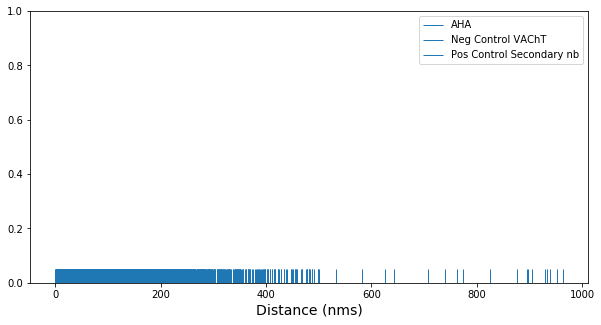

In [29]:
fig=plt.figure(figsize=(10,5))
for prot in df_ecm["Protein"].unique():
    print(prot)
    g=sns.rugplot(df_ecm[df_ecm["Protein"]==prot]["distance to nearest funcat centroid"],
               label=prot
              )
#g=sns.kdeplot(df_funcat["distance to nearest ecm centroid [nms]"],shade=True)
#g=sns.distplot(df_ecm["distance to nearest synapse centroid [nms]"],label="Distance to nearest synapse")
    #g.set_xticks(np.linspace(0,100,11))
    #g.set_xlim([-200,2000])
    plt.legend()

g.set_xlabel('Distance (nms)',fontsize=14)


### Graph for distances from FUNCAT spots to ECM

AHA
Neg Control VAChT
Pos Control Secondary nb


Text(0.5, 0, 'Distance (nms)')

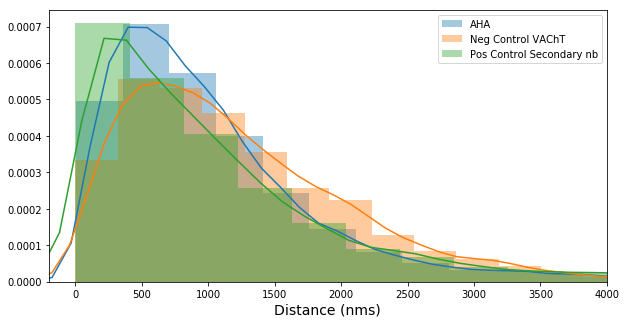

In [25]:
fig=plt.figure(figsize=(10,5))
for prot in df_funcat["Protein"].unique():
    print(prot)
    g=sns.distplot(df_funcat[df_funcat["Protein"]==prot]["distance to nearest ecm centroid [nms]"],
               label=prot
              )
#g=sns.kdeplot(df_funcat["distance to nearest ecm centroid [nms]"],shade=True)
#g=sns.distplot(df_ecm["distance to nearest synapse centroid [nms]"],label="Distance to nearest synapse")
    #g.set_xticks(np.linspace(0,100,11))
    g.set_xlim([-200,4000])
    plt.legend()

g.set_xlabel('Distance (nms)',fontsize=14)



### Picture to explain

Image name: /Volumes/ukps-all$/user/tdanko/Imaging/1_ECM/Culture_ClickChemistry/20190522_funcatdbco_TNR_analyse519/STED/ctrl_secondarymouse635/TIF_imp/tnr580_01_ExpControl
Experimental condition: TIF_imp


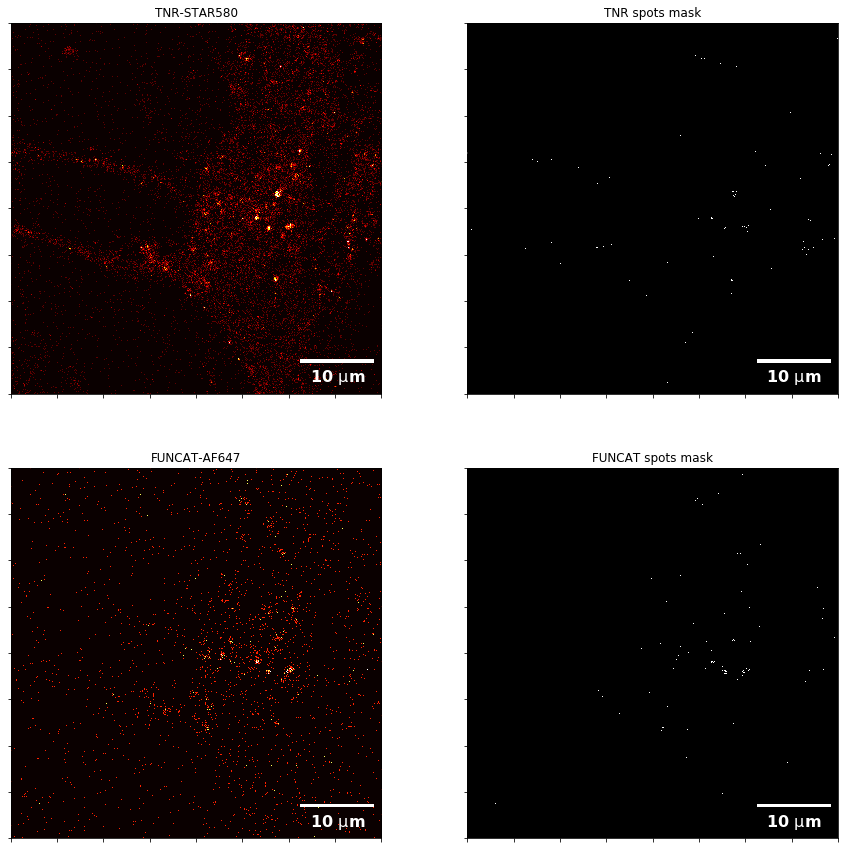

In [23]:
randomno=np.random.randint(1,len(results["filename"]))
ecm_channel_no=2
funcat_channel_no=1


ecm_image_name=results["filename"][randomno]+" Ch"+str(ecm_channel_no)+" {0}.tif"
funcat_image_name=results["filename"][randomno]+" Ch"+str(funcat_channel_no)+" {0}.tif"


print("Image name:",results["filename"][randomno])
print("Experimental condition:",results["exp condition"][randomno])
ecm_image=pims.open(ecm_image_name)[0]
funcat_image=pims.open(funcat_image_name)[0]
ecm_mask=results["TNR spots mask"][randomno]
funcat_mask=results["funcat spots mask"][randomno]
    
figure=plt.figure(figsize=(15,15))

figure.add_subplot(221)
plt.imshow(ecm_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(ecm_image))
plt.title('TNR-STAR580')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(25, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter    
plt.gca().add_artist(scalebar)


figure.add_subplot(222)
plt.imshow(ecm_mask,interpolation='none',cmap='hot')
plt.title('TNR spots mask')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(25, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)


figure.add_subplot(223)
plt.imshow(funcat_image,interpolation='none',cmap='hot',vmin=3*np.min(ecm_image),vmax=0.4*np.max(funcat_image))
plt.title('FUNCAT-AF647')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(25, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
    
plt.gca().add_artist(scalebar)

figure.add_subplot(224)
plt.imshow(funcat_mask,interpolation='none',cmap='hot')
plt.title('FUNCAT spots mask')
plt.grid(visible=False)
plt.xticks(visible=False)
plt.yticks(visible=False)
scalebar = ScaleBar(25, 'nm', dimension='si-length',box_alpha=0,location='lower right',length_fraction=0.2,
                       font_properties={'size':16,'weight':'bold'},color='white',border_pad=0.5) # 1 pixel = 0.2 meter
plt.gca().add_artist(scalebar)

AHA
Neg Control VAChT
Pos Control Secondary nb


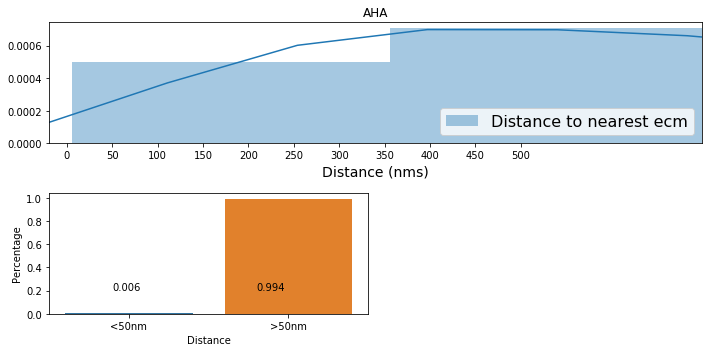

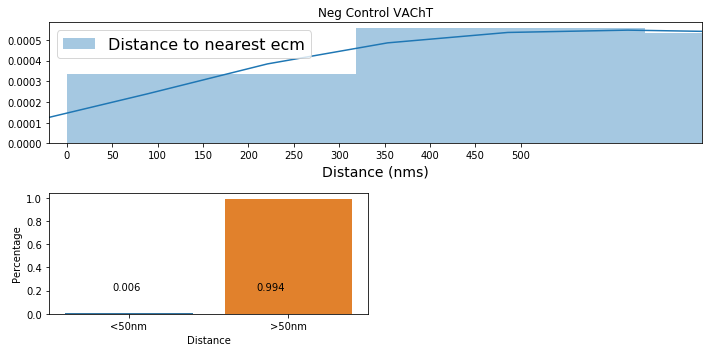

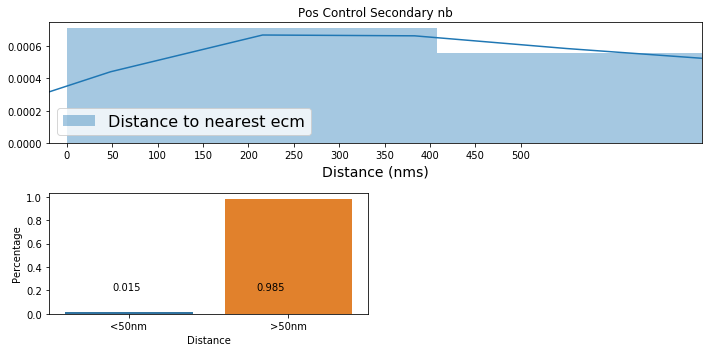

In [24]:
for protein in df_funcat["Protein"].unique():
    print(protein)
    df2plot=df_funcat[df_funcat["Protein"]==protein]
    #df2plot=df_funcat[(df_funcat["Protein"]==protein)]
    fig=plt.figure(figsize=(10,5))
    fig.add_subplot(211)
    g=sns.distplot(df2plot["distance to nearest ecm centroid [nms]"],label="Distance to nearest ecm")
    g.set_xticks(np.linspace(0,500,11))
    g.set_xlim([-20,700])
    plt.legend(fontsize=16)
    g.set_xlabel('Distance (nms)',fontsize=14)
    plt.title(protein)
    
    fig.add_subplot(223)
    dfcount=df2plot.groupby("Distance to ecm").count()
    smallerthan=dfcount["filename"].unique()[0]
    biggerthan=dfcount["filename"].unique()[1]
    propsmaller=smallerthan/(smallerthan+biggerthan)
    propbigger=biggerthan/(smallerthan+biggerthan)
    dfprops={'Distance':['<50nm','>50nm'],'Percentage':[propsmaller,propbigger]}
    dfprops=pd.DataFrame(dfprops)
    sns.barplot(x="Distance",y="Percentage",data=dfprops)
    plt.text(x=-0.1,y=0.2,s=np.round(propsmaller,3))
    plt.text(x=0.8,y=0.2,s=np.round(propbigger,3))
    
    fig.tight_layout()